# SCOUTIM PREDICTION CASE STUDY
****************************************************
**İş Problemi**
- Scout’lar tarafından izlenen futbolcuların özelliklerine verilen puanlara göre, oyuncuların hangi sınıf (average, highlighted) oyuncu olduğunu tahminleme.

**Veri Seti Hikayesi**
- Veri seti Scoutium’dan maçlarda gözlemlenen futbolcuların özelliklerine göre scoutların değerlendirdikleri futbolcuların, maç içerisinde puanlanan özellikleri ve puanlarını içeren bilgilerden oluşmaktadır.

In [41]:
# Kütüphanelerin Yüklenmesi
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import time
from pandas.core.common import random_state
import logging

# ML yüklenmesi
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, validation_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from streamlit import dataframe
from twisted.words.protocols.irc import attributes
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.exceptions import ConvergenceWarning

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 55)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)
warnings.simplefilter('ignore', category=UserWarning)
logging.getLogger().setLevel(logging.ERROR)

In [2]:
attributes = pd.read_csv('Datasets/Scoutium_Data/scoutium_attributes.csv', delimiter=';')
potential = pd.read_csv('Datasets/Scoutium_Data/scoutium_potential_labels.csv', delimiter=';')

In [3]:
df_ = attributes.merge(potential, on= ['player_id', 'match_id', 'evaluator_id', 'task_response_id'])
df = df_.copy()

### 1.DATA INFROMATION AND PREPROCESSING

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10730 entries, 0 to 10729
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   task_response_id  10730 non-null  int64  
 1   match_id          10730 non-null  int64  
 2   evaluator_id      10730 non-null  int64  
 3   player_id         10730 non-null  int64  
 4   position_id       10730 non-null  int64  
 5   analysis_id       10730 non-null  int64  
 6   attribute_id      10730 non-null  int64  
 7   attribute_value   10730 non-null  float64
 8   potential_label   10730 non-null  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 754.6+ KB


task_response_id  match_id  evaluator_id   player_id  position_id  \
count         10730.000 10730.000     10730.000   10730.000    10730.000   
mean           5252.082 63199.764    175246.880 1525548.486        5.347   
std             268.254   663.917     43667.459  201751.875        2.861   
min            4915.000 60549.000    130478.000 1355710.000        1.000   
25%            4997.000 62988.000    151191.000 1367783.000        3.000   
50%            5162.000 63166.000    151191.000 1372670.000        6.000   
75%            5524.000 63627.000    177676.000 1719053.000        8.000   
max            5642.000 64045.000    256441.000 1909728.000       10.000   

       analysis_id  attribute_id  attribute_value  
count    10730.000     10730.000        10730.000  
mean  12822388.800      4348.609           55.271  
std       2676.866        26.980           16.048  
min   12818481.000      4322.000            1.000  
25%   12819582.000      4330.000           45.000  
50%   12822231.000      4342.000           56.000  
75%   12825047.000      4353.000           67.000  
max   12825764.000      4426.000          100.000

In [5]:
def check_df(dataframe):
    print('##################### Shape #####################')
    print(dataframe.shape)
    print('##################### Types #####################')
    print(dataframe.dtypes)
    print('##################### Head #####################')
    print(dataframe.head(3))
    print('############### TAIL ###############')
    print(dataframe.tail(3))
    print('############### NA ###############')
    print(dataframe.isnull().sum())
    print('############### Quantiles ###############')
    numeric_columns = dataframe.select_dtypes(include = ['number']).columns
    print(dataframe[numeric_columns].quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [6]:
check_df(df)

##################### Shape #####################
(10730, 9)
##################### Types #####################
task_response_id      int64
match_id              int64
evaluator_id          int64
player_id             int64
position_id           int64
analysis_id           int64
attribute_id          int64
attribute_value     float64
potential_label      object
dtype: object
##################### Head #####################
   task_response_id  match_id  evaluator_id  player_id  position_id  \
0              4915     62935        177676    1361061            2   
1              4915     62935        177676    1361061            2   
2              4915     62935        177676    1361061            2   

   analysis_id  attribute_id  attribute_value potential_label  
0     12818495          4322           56.000         average  
1     12818495          4323           56.000         average  
2     12818495          4324           67.000         average  
############### TAIL ############

In [7]:
# position_id içindeki 1 numaralı değerlerin silinmesi
df = df[df['position_id'] != 1]

In [8]:
df['position_id'].unique()

array([ 2, 10,  6,  5,  9,  7,  4,  3,  8], dtype=int64)

In [9]:
df['potential_label'].value_counts()

potential_label
average          7922
highlighted      1972
below_average     136
Name: count, dtype: int64

In [10]:
# potential_label below_average olanlar çıkarılır.
df = df[df['potential_label'] != 'below_average']

In [11]:
df['potential_label'].unique()

array(['average', 'highlighted'], dtype=object)

In [12]:
df.shape

(9894, 9)

#### 1.1 Kategorik ve Sayısal Değişkenlerin Belirlenmesi ve Analizi

In [13]:
def grab_col_name(dataframe, cat_th = 10, car_th = 20):

    #cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == '0']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() <cat_th and
                   dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == 'O']

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    #num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    return cat_cols, num_cols, cat_but_car

In [14]:
cat_cols, num_cols, cat_but_car = grab_col_name(df)

Observations: 9894
Variables: 9
cat_cols: 1
num_cols: 7
cat_but_car: 0


In [15]:
# Kategorik değişkenlerin analizi
def cat_summary(dataframe, col_name, plot=False):
    summary_df = pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                               "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)})
    print("######################### *** #########################")
    print(summary_df)
    print("######################### *** #########################")
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(18, 5))
        counts = dataframe[col_name].value_counts()
        ratios = 100 * counts / len(dataframe)

        # Count Plot
        ax = sns.countplot(x=col_name, data=dataframe, ax=axs[0], order=counts.index)
        axs[0].set_title("Frequency of " + col_name)
        axs[0].tick_params(axis='x', rotation=90)
        for i, p in enumerate(ax.patches):
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 0.01 * max(counts),
                    f'{ratios.iloc[i]:.2f}%',
                    ha="center", va="bottom",rotation = 60)

        # Pie Chart
        wedges, texts, autotexts = axs[1].pie(x=counts, autopct='%1.1f%%', textprops=dict(color="w"))
        axs[1].set_title("Pie chart of " + col_name)
        # Add legend to pie chart
        axs[1].legend(wedges, counts.index,
                      title=col_name,
                      loc="center left",
                      bbox_to_anchor=(1, 0, 0.5, 1))

        plt.tight_layout()
        plt.show()

######################### *** #########################
             position_id  Ratio
position_id                    
2                   1972 19.931
6                   1428 14.433
10                  1054 10.653
7                    986  9.966
8                    986  9.966
3                    952  9.622
9                    850  8.591
4                    850  8.591
5                    816  8.247
######################### *** #########################


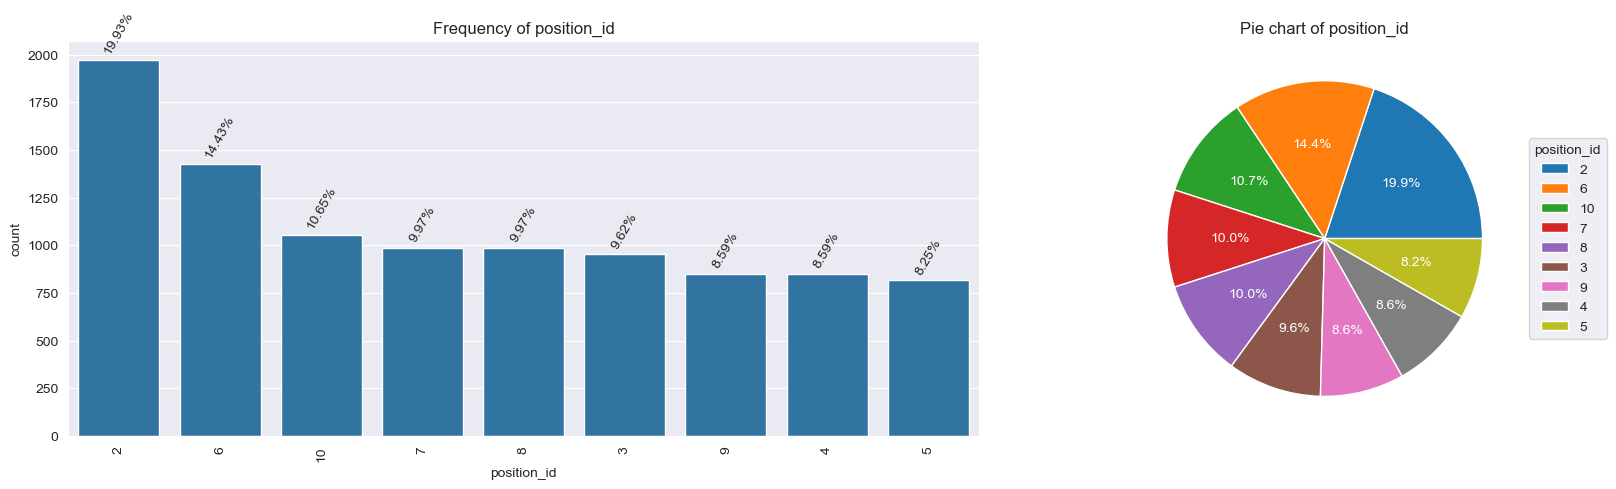

In [16]:
for col in cat_cols:
    cat_summary(df, col, plot = True)

In [17]:
# Sayısal değişkenlerin analizi
def num_summary(dataframe, numerical_col, plot = False):
    quantiles = [0.25, 0.50, 0.75, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    print('********************************************')

    if plot:
        fig, axs = plt.subplots(2,2, figsize = (12, 10))

        # Histogram
        plt.subplot(2,2,1)
        dataframe[numerical_col].hist(bins = 50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col + 'Distribution')

        # Density Plot
        plt.subplot(2, 2, 3)
        sns.kdeplot(dataframe[numerical_col], shade=True)
        plt.xlabel(numerical_col)
        plt.title(numerical_col + ' Density')

        # Boxplot
        plt.subplot(2,2,2)
        sns.boxplot(y=numerical_col, data = dataframe)
        plt.title('Boxplot of ' + numerical_col)
        plt.xticks(rotation = 90)

        # QQ Plot
        plt.subplot(2,2,4)
        stats.probplot(dataframe[numerical_col], dist = 'norm', plot = plt)
        plt.title(numerical_col + 'QQ Plot')

        plt.tight_layout
        plt.show()

count   9894.000
mean    5253.674
std      268.122
min     4915.000
25%     4997.000
50%     5162.000
75%     5524.000
99%     5642.000
max     5642.000
Name: task_response_id, dtype: float64
********************************************


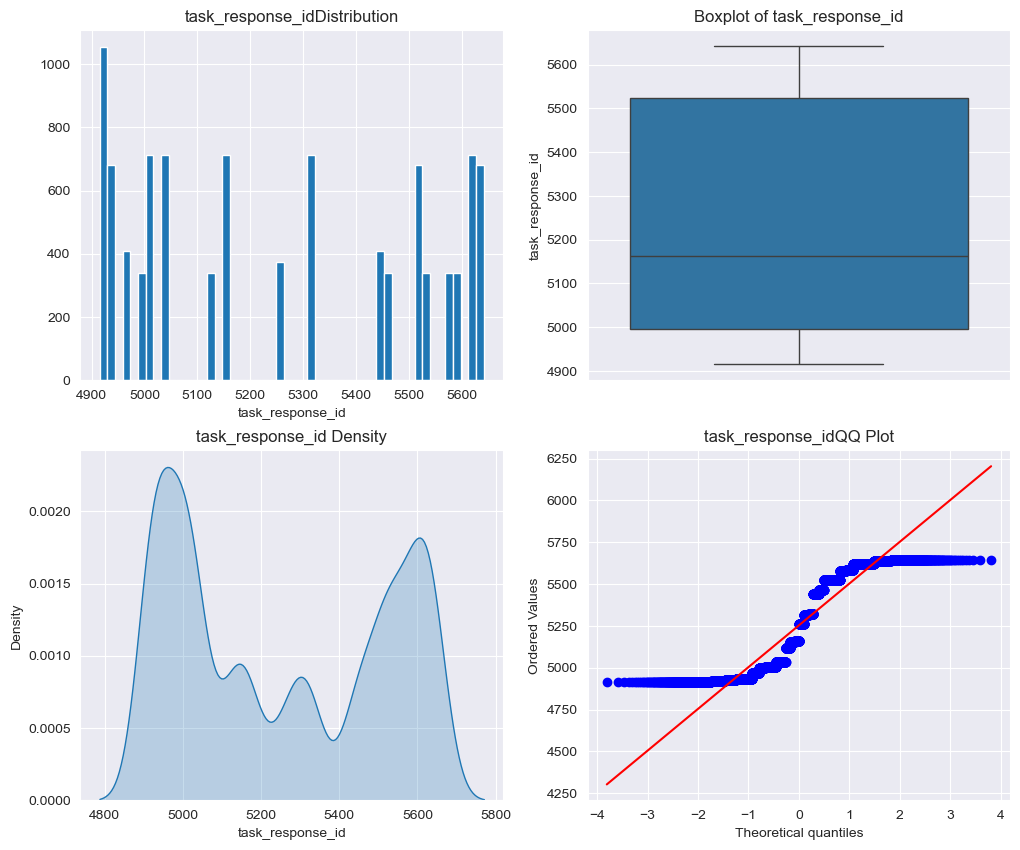

count    9894.000
mean    63199.093
std       666.085
min     60549.000
25%     62988.000
50%     63166.000
75%     63627.000
99%     64045.000
max     64045.000
Name: match_id, dtype: float64
********************************************


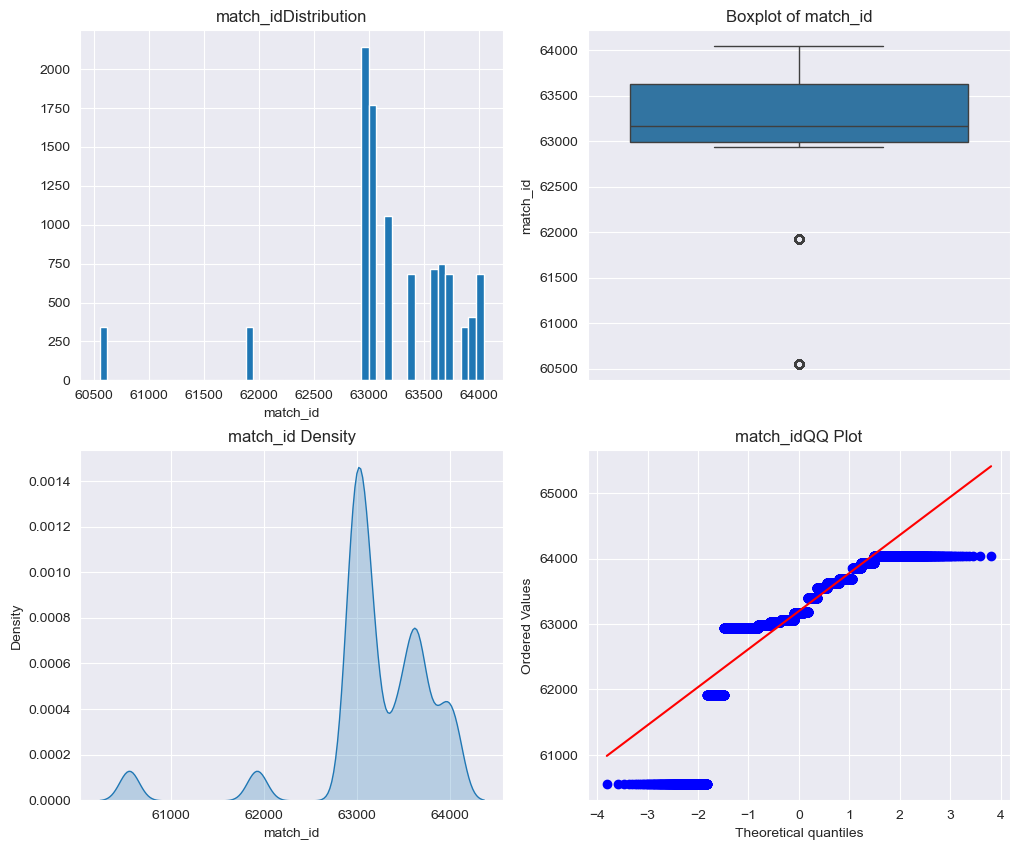

count     9894.000
mean    175284.113
std      43563.191
min     130478.000
25%     151191.000
50%     151191.000
75%     177676.000
99%     256441.000
max     256441.000
Name: evaluator_id, dtype: float64
********************************************


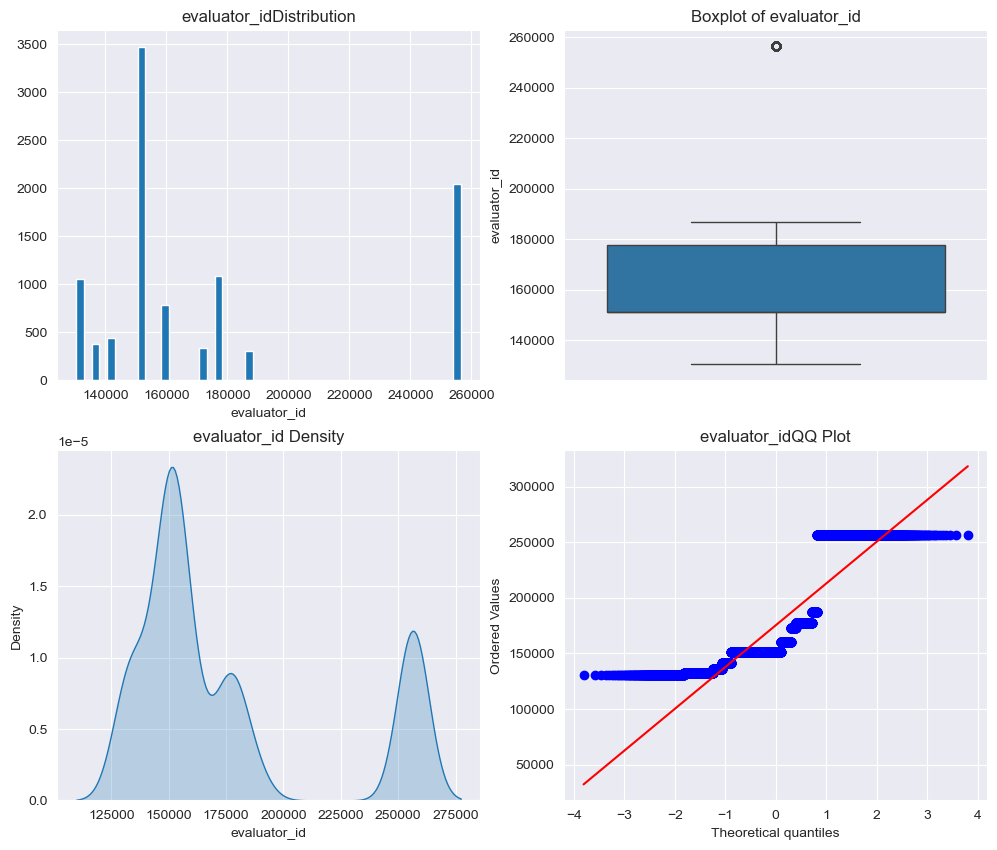

count      9894.000
mean    1528313.031
std      203116.033
min     1355710.000
25%     1367783.000
50%     1372673.000
75%     1719653.000
99%     1909532.000
max     1909728.000
Name: player_id, dtype: float64
********************************************


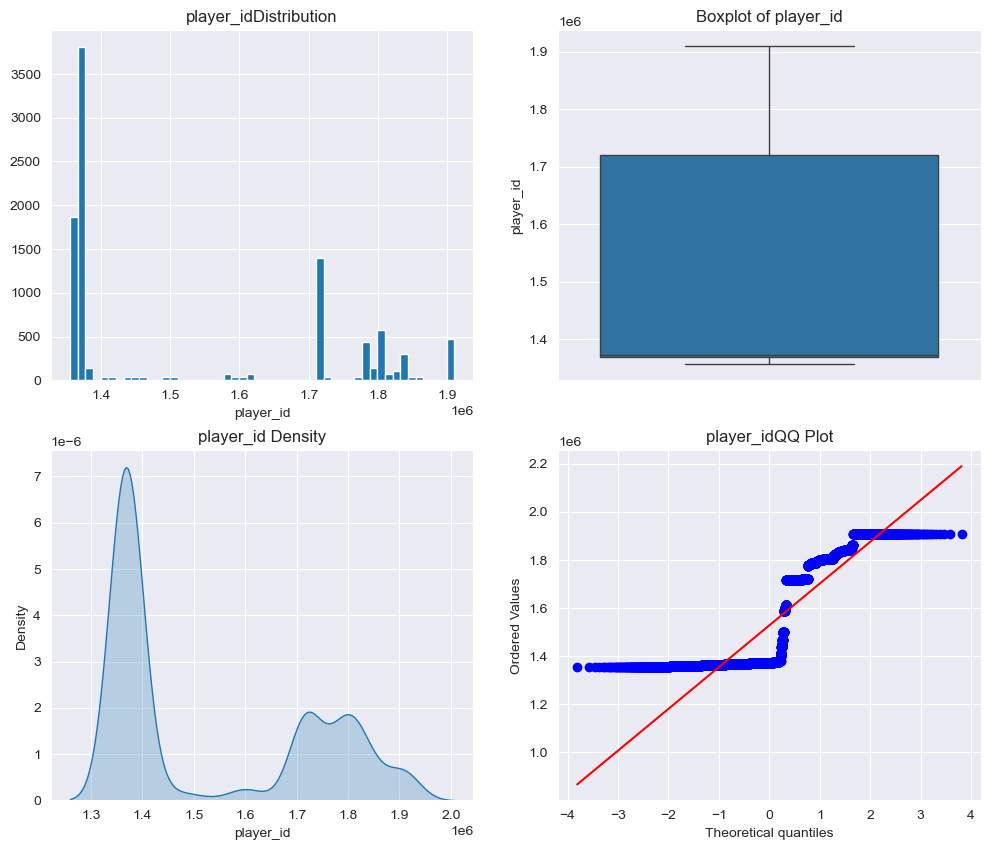

count       9894.000
mean    12822406.069
std         2673.436
min     12818484.000
25%     12819582.000
50%     12822231.000
75%     12825047.000
99%     12825761.000
max     12825763.000
Name: analysis_id, dtype: float64
********************************************


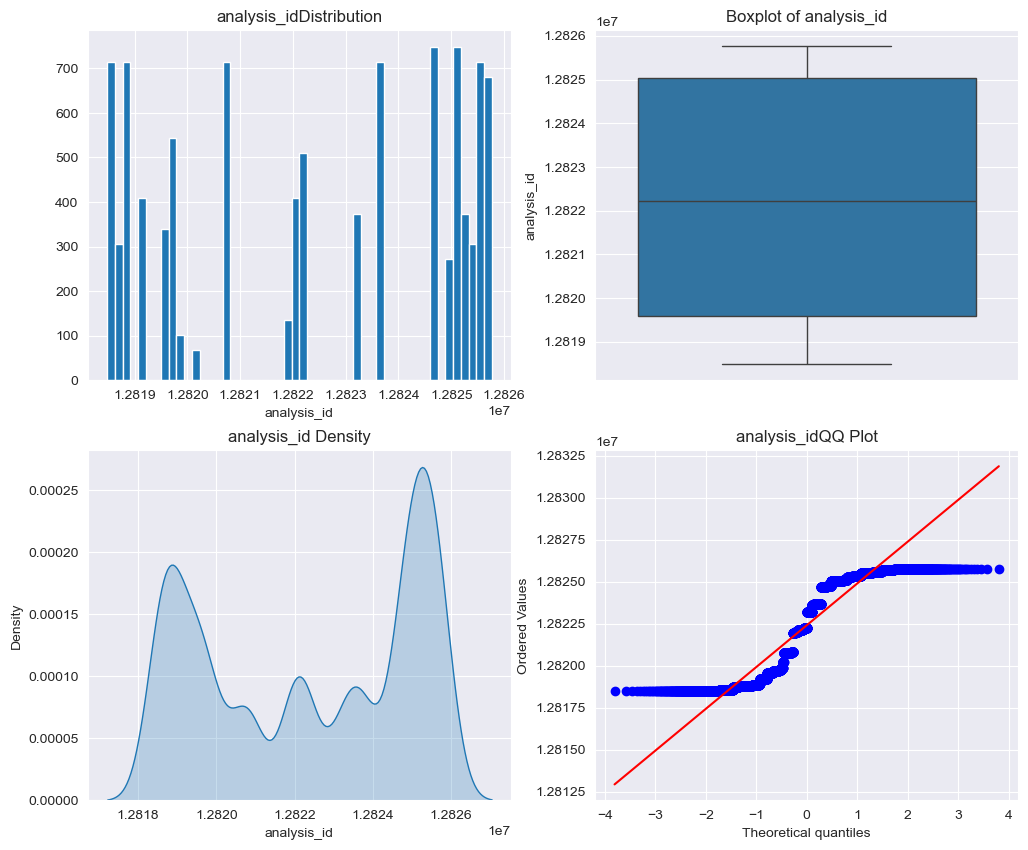

count   9894.000
mean    4348.676
std       26.848
min     4322.000
25%     4330.000
50%     4342.500
75%     4353.000
99%     4426.000
max     4426.000
Name: attribute_id, dtype: float64
********************************************


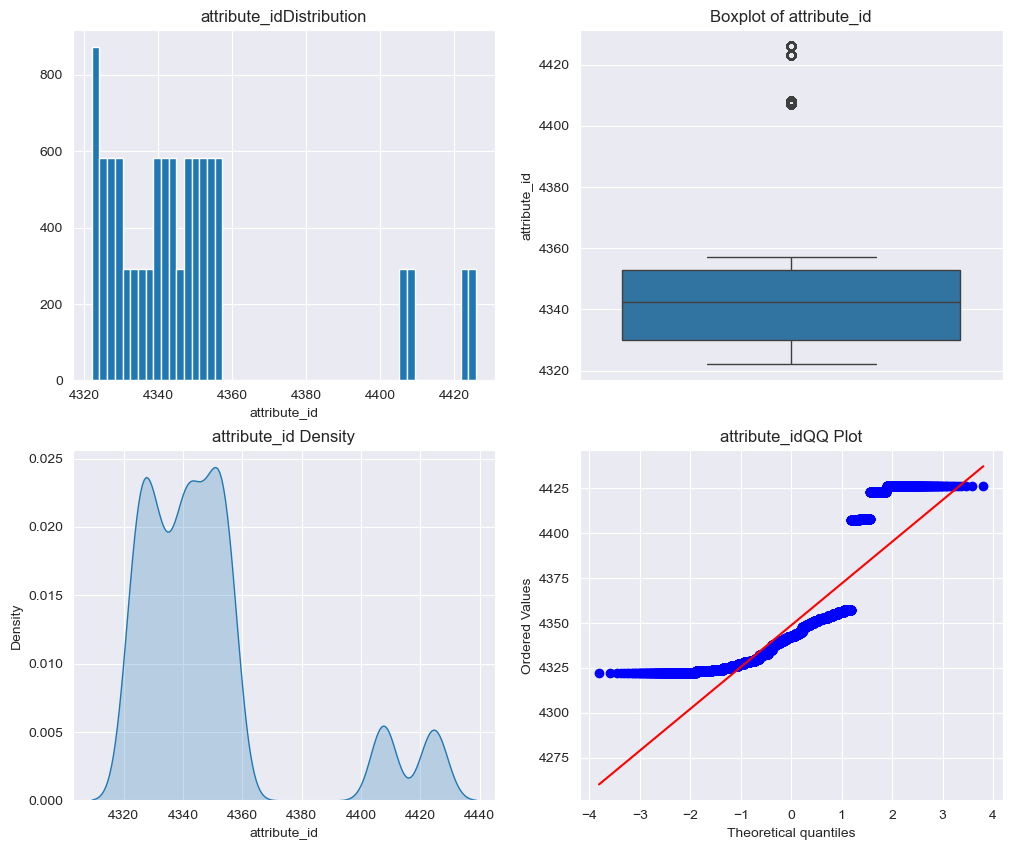

count   9894.000
mean      55.522
std       15.942
min        1.000
25%       45.000
50%       56.000
75%       67.000
99%       78.000
max      100.000
Name: attribute_value, dtype: float64
********************************************


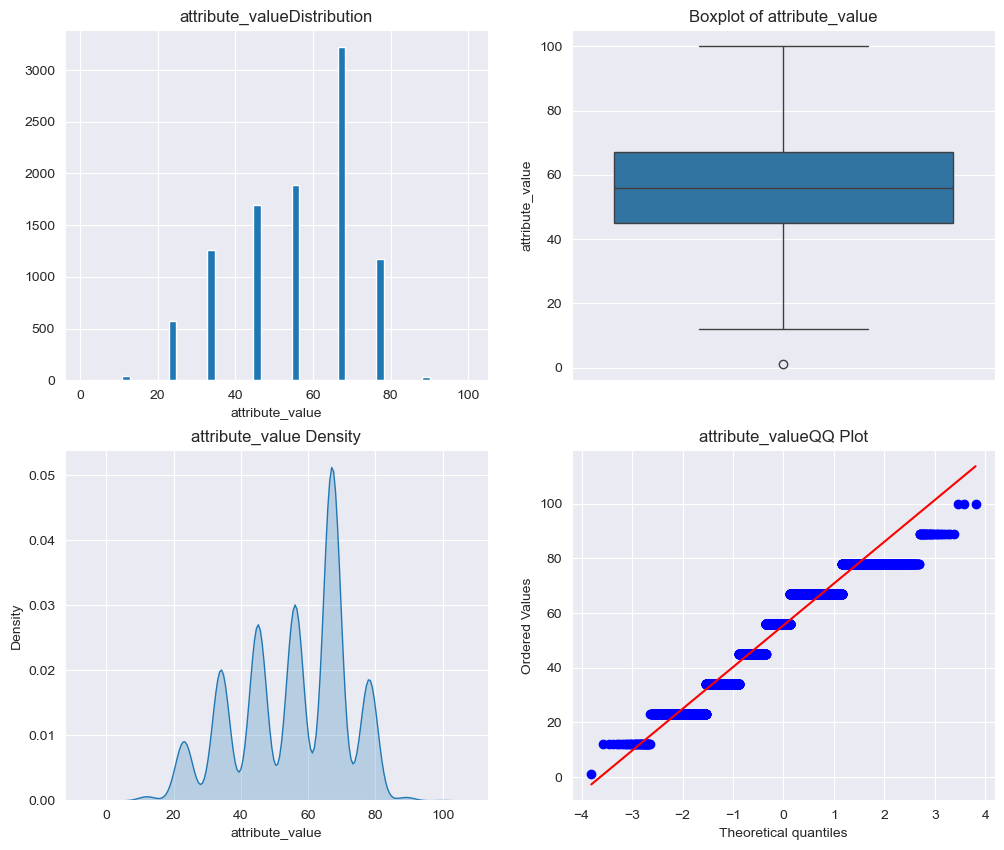

In [18]:
for col in num_cols:
    num_summary(df, col, plot = True)

In [19]:
# Hedef Değişken Analizi
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "nunique"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "potential_label", col)

                 task_response_id
potential_label                  
average                        29
highlighted                    24


                 match_id
potential_label          
average                17
highlighted            15


                 evaluator_id
potential_label              
average                    10
highlighted                 9


                 player_id
potential_label           
average                209
highlighted             56


                 analysis_id
potential_label             
average                  233
highlighted               58


                 attribute_id
potential_label              
average                    34
highlighted                34


                 attribute_value
potential_label                 
average                       10
highlighted                    9




In [20]:
# Hedef değişkenin kategorik değişkenlerle analizi
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
target_summary_with_num(df, "potential_label", "attribute_value")

                 attribute_value
potential_label                 
average                   54.528
highlighted               59.514




### 2. PIVOT TABLE OLUŞTURMA

In [21]:
pivot_df = pd.pivot_table(df, index = ['player_id', 'position_id', 'potential_label'], columns = ['attribute_id'], values = 'attribute_value',)

In [22]:
pivot_df.head()

attribute_id                            4322   4323   4324   4325   4326  \
player_id position_id potential_label                                      
1355710   7           average         50.500 50.500 34.000 50.500 45.000   
1356362   9           average         67.000 67.000 67.000 67.000 67.000   
1356375   3           average         67.000 67.000 67.000 67.000 67.000   
          4           average         67.000 78.000 67.000 67.000 67.000   
1356411   9           average         67.000 67.000 78.000 78.000 67.000   

attribute_id                            4327   4328   4329   4330   4332  \
player_id position_id potential_label                                      
1355710   7           average         45.000 45.000 45.000 50.500 56.000   
1356362   9           average         67.000 67.000 67.000 67.000 67.000   
1356375   3           average         67.000 67.000 78.000 67.000 67.000   
          4           average         78.000 78.000 78.000 56.000 67.000   
1356411   9           average         67.000 67.000 67.000 89.000 78.000   

attribute_id                            4333   4335   4338   4339   4340  \
player_id position_id potential_label                                      
1355710   7           average         39.500 34.000 39.500 39.500 45.000   
1356362   9           average         67.000 67.000 67.000 67.000 67.000   
1356375   3           average         78.000 56.000 67.000 67.000 67.000   
          4           average         67.000 67.000 78.000 78.000 56.000   
1356411   9           average         67.000 67.000 67.000 56.000 56.000   

attribute_id                            4341   4342   4343   4344   4345  \
player_id position_id potential_label                                      
1355710   7           average         45.000 50.500 28.500 23.000 39.500   
1356362   9           average         67.000 67.000 67.000 56.000 67.000   
1356375   3           average         67.000 67.000 56.000 56.000 67.000   
          4           average         67.000 67.000 45.000 45.000 56.000   
1356411   9           average         67.000 78.000 56.000 56.000 67.000   

attribute_id                            4348   4349   4350   4351   4352  \
player_id position_id potential_label                                      
1355710   7           average         28.500 28.500 45.000 50.500 56.000   
1356362   9           average         67.000 56.000 67.000 67.000 67.000   
1356375   3           average         67.000 56.000 56.000 67.000 67.000   
          4           average         67.000 67.000 67.000 67.000 78.000   
1356411   9           average         56.000 67.000 56.000 67.000 67.000   

attribute_id                            4353   4354   4355   4356   4357  \
player_id position_id potential_label                                      
1355710   7           average         34.000 39.500 50.500 34.000 34.000   
1356362   9           average         67.000 78.000 67.000 67.000 67.000   
1356375   3           average         67.000 78.000 67.000 67.000 67.000   
          4           average         67.000 67.000 67.000 56.000 67.000   
1356411   9           average         56.000 67.000 67.000 56.000 67.000   

attribute_id                            4407   4408   4423   4426  
player_id position_id potential_label                              
1355710   7           average         56.000 34.000 34.000 56.000  
1356362   9           average         67.000 67.000 56.000 78.000  
1356375   3           average         67.000 67.000 56.000 78.000  
          4           average         56.000 67.000 45.000 56.000  
1356411   9           average         89.000 56.000 67.000 78.000

In [23]:
pivot_df.reset_index(inplace = True) # indexleri sıfırlama
pivot_df.columns = pivot_df.columns.astype(str) # columnları stringe çevirme

In [24]:
pivot_df.head()

attribute_id  player_id  position_id potential_label   4322   4323   4324  \
0               1355710            7         average 50.500 50.500 34.000   
1               1356362            9         average 67.000 67.000 67.000   
2               1356375            3         average 67.000 67.000 67.000   
3               1356375            4         average 67.000 78.000 67.000   
4               1356411            9         average 67.000 67.000 78.000   

attribute_id   4325   4326   4327   4328   4329   4330   4332   4333   4335  \
0            50.500 45.000 45.000 45.000 45.000 50.500 56.000 39.500 34.000   
1            67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000   
2            67.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000 56.000   
3            67.000 67.000 78.000 78.000 78.000 56.000 67.000 67.000 67.000   
4            78.000 67.000 67.000 67.000 67.000 89.000 78.000 67.000 67.000   

attribute_id   4338   4339   4340   4341   4342   4343   4344   4345   4348  \
0            39.500 39.500 45.000 45.000 50.500 28.500 23.000 39.500 28.500   
1            67.000 67.000 67.000 67.000 67.000 67.000 56.000 67.000 67.000   
2            67.000 67.000 67.000 67.000 67.000 56.000 56.000 67.000 67.000   
3            78.000 78.000 56.000 67.000 67.000 45.000 45.000 56.000 67.000   
4            67.000 56.000 56.000 67.000 78.000 56.000 56.000 67.000 56.000   

attribute_id   4349   4350   4351   4352   4353   4354   4355   4356   4357  \
0            28.500 45.000 50.500 56.000 34.000 39.500 50.500 34.000 34.000   
1            56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000   
2            56.000 56.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000   
3            67.000 67.000 67.000 78.000 67.000 67.000 67.000 56.000 67.000   
4            67.000 56.000 67.000 67.000 56.000 67.000 67.000 56.000 67.000   

attribute_id   4407   4408   4423   4426  
0            56.000 34.000 34.000 56.000  
1            67.000 67.000 56.000 78.000  
2            67.000 67.000 56.000 78.000  
3            56.000 67.000 45.000 56.000  
4            89.000 56.000 67.000 78.000

#### 2.1 Kategorik ve Sayısal Değişkenlerin Pivot Tablosu Bazında Belirlenmesi ve Analizi

In [25]:
cat_cols, num_cols, cat_but_car = grab_col_name(pivot_df)

Observations: 271
Variables: 37
cat_cols: 6
num_cols: 30
cat_but_car: 0


######################### *** #########################
             position_id  Ratio
position_id                    
2                     53 19.557
6                     41 15.129
10                    29 10.701
7                     28 10.332
3                     26  9.594
8                     25  9.225
4                     24  8.856
5                     23  8.487
9                     22  8.118
######################### *** #########################


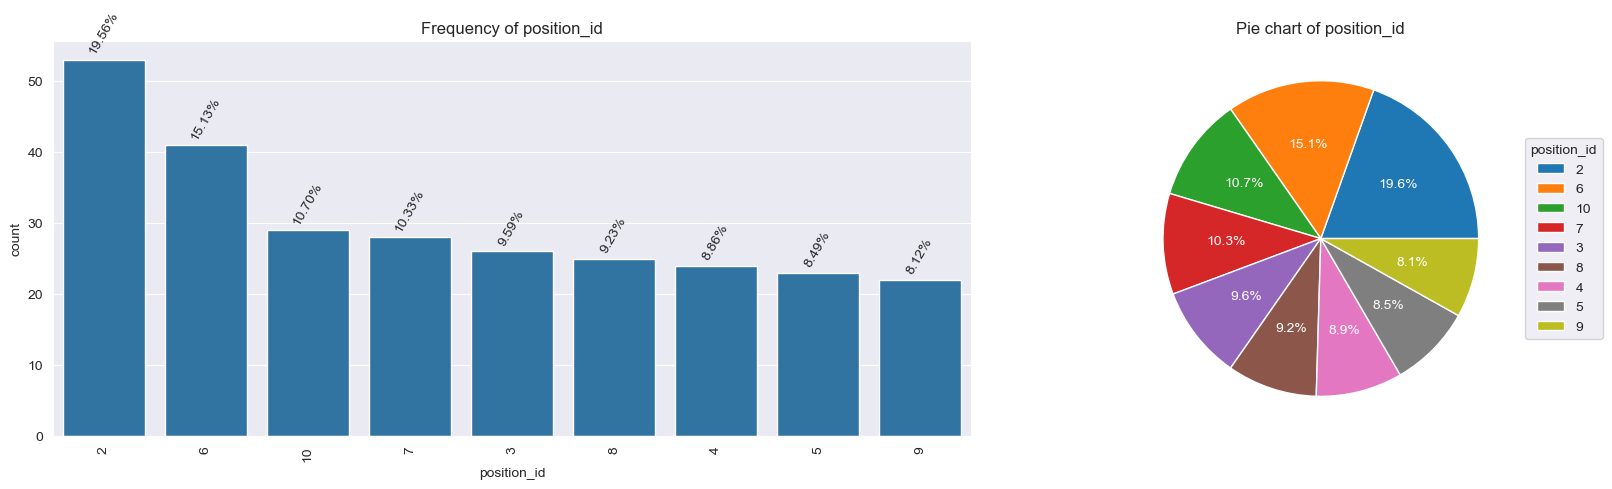

######################### *** #########################
        4324  Ratio
4324               
67.000    93 34.317
34.000    45 16.605
56.000    42 15.498
45.000    39 14.391
78.000    35 12.915
23.000    11  4.059
72.500     4  1.476
41.333     1  0.369
61.500     1  0.369
######################### *** #########################


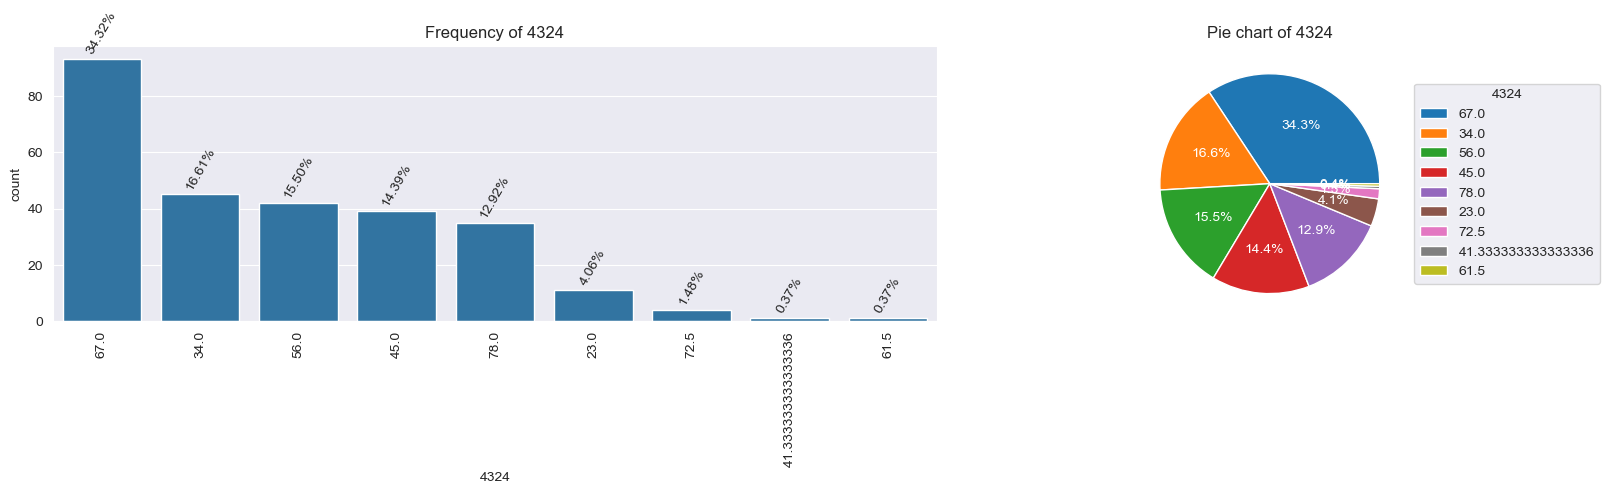

######################### *** #########################
        4328  Ratio
4328               
67.000    85 31.365
45.000    56 20.664
56.000    48 17.712
78.000    44 16.236
34.000    25  9.225
23.000     6  2.214
50.500     3  1.107
72.500     3  1.107
89.000     1  0.369
######################### *** #########################


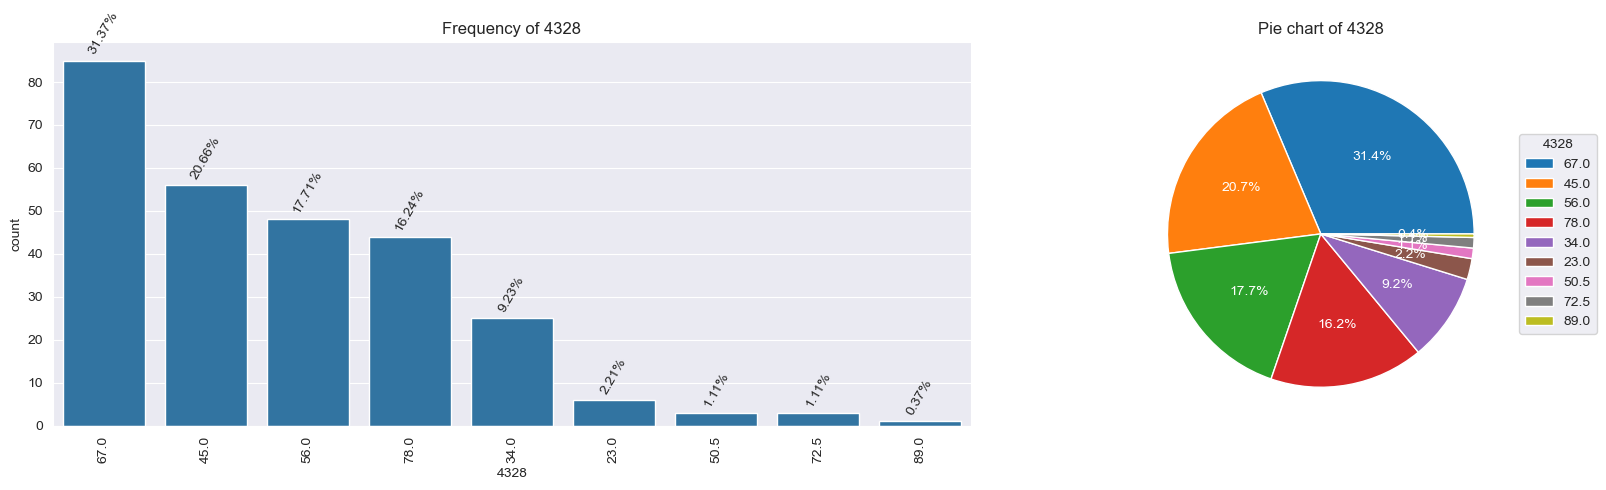

######################### *** #########################
        4352  Ratio
4352               
67.000   112 41.328
56.000    56 20.664
45.000    44 16.236
34.000    30 11.070
78.000    13  4.797
23.000    12  4.428
61.500     3  1.107
12.000     1  0.369
######################### *** #########################


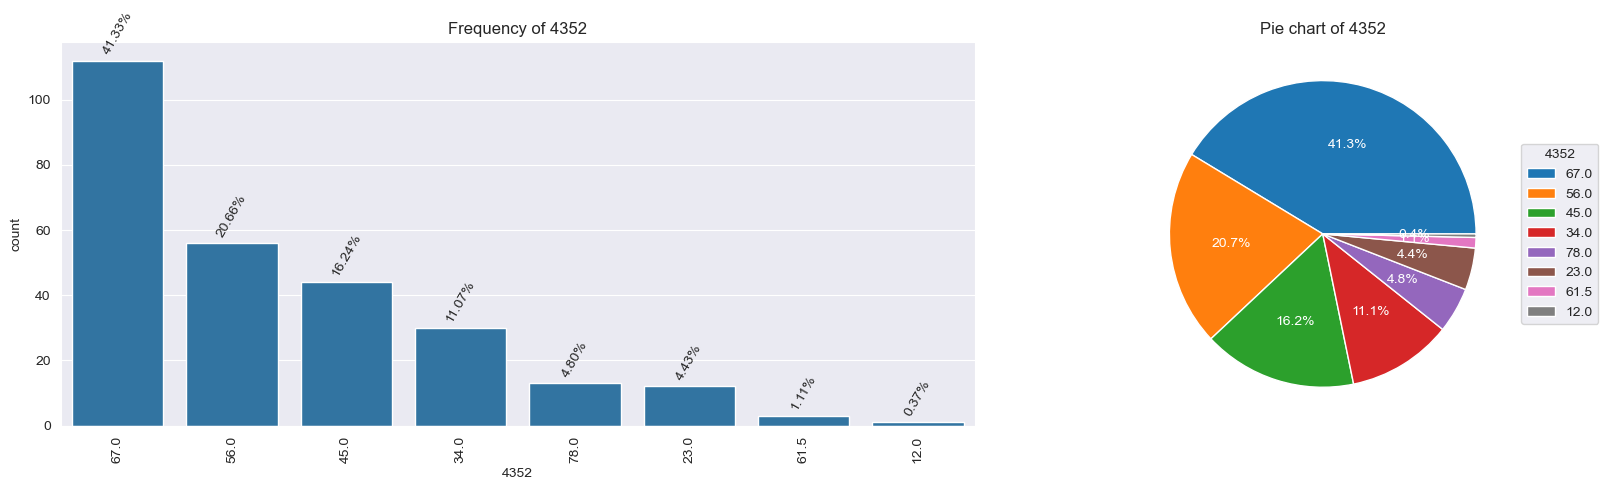

######################### *** #########################
        4357  Ratio
4357               
67.000   123 45.387
45.000    56 20.664
56.000    33 12.177
34.000    30 11.070
78.000    13  4.797
23.000    12  4.428
72.500     2  0.738
50.500     1  0.369
39.500     1  0.369
######################### *** #########################


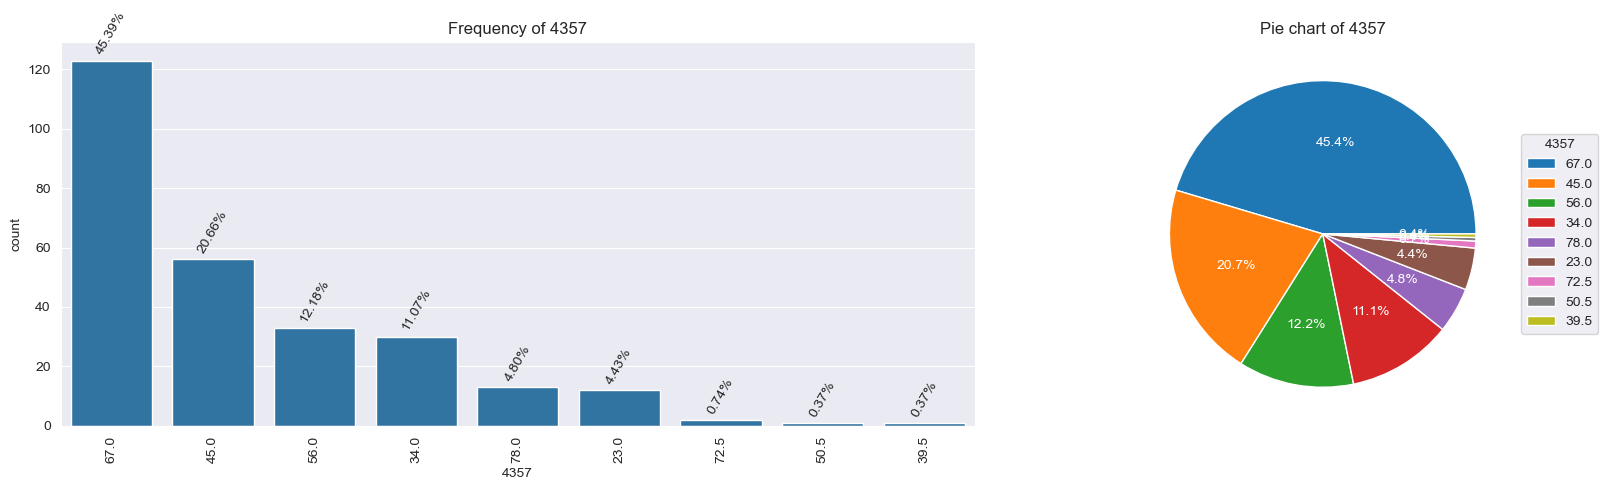

######################### *** #########################
        4423  Ratio
4423               
67.000    85 31.365
34.000    66 24.354
56.000    42 15.498
45.000    36 13.284
23.000    30 11.070
78.000     6  2.214
61.500     4  1.476
39.500     1  0.369
50.500     1  0.369
######################### *** #########################


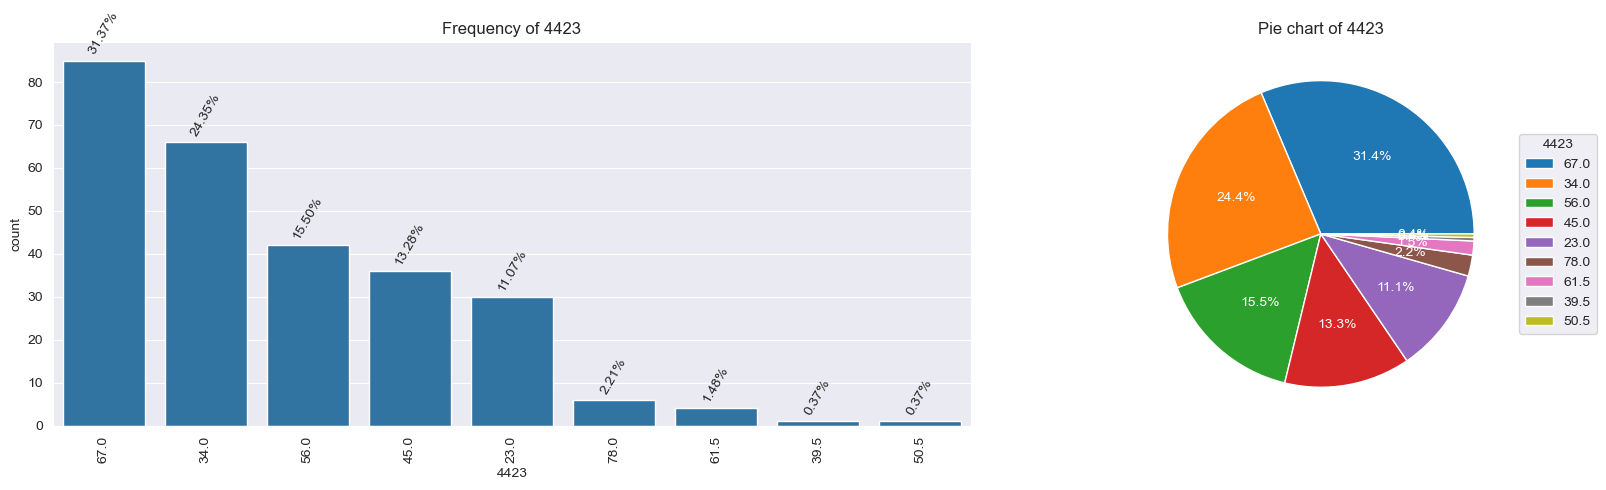

In [26]:
for col in cat_cols:
    cat_summary(pivot_df, col, plot = True)

count       271.000
mean    1538154.742
std      204999.321
min     1355710.000
25%     1368264.000
50%     1373419.000
75%     1720508.000
99%     1908002.500
max     1909728.000
Name: player_id, dtype: float64
********************************************


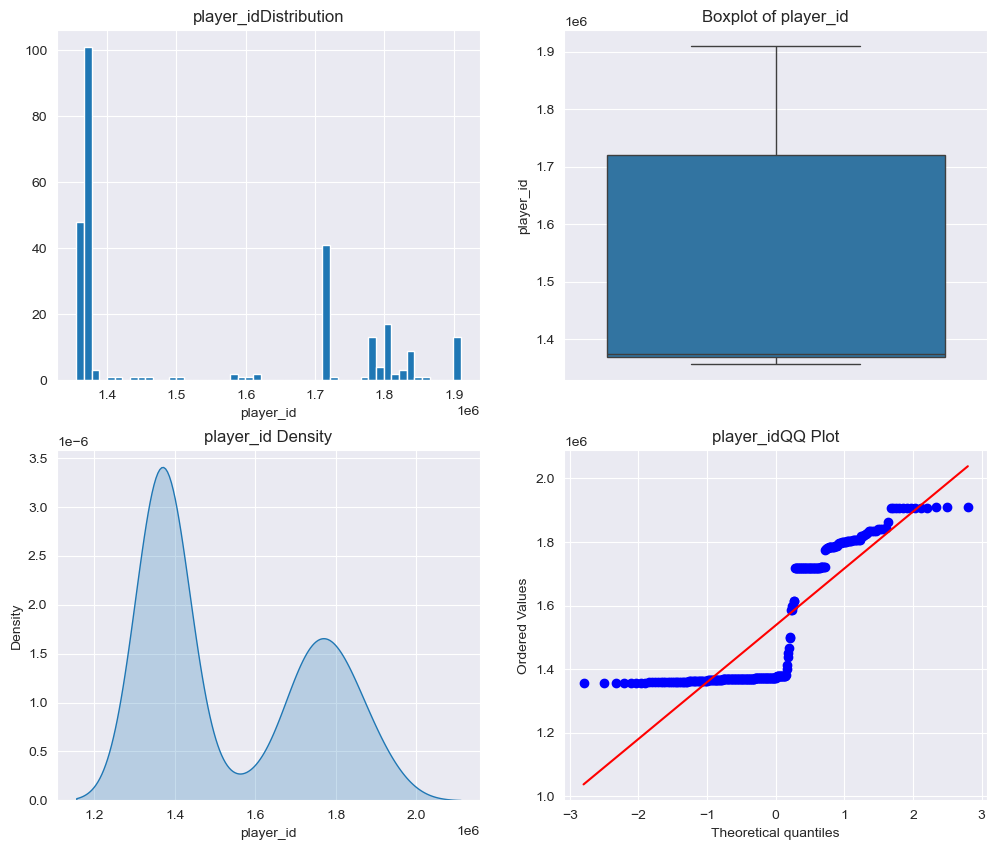

count   271.000
mean     58.368
std      14.527
min      23.000
25%      45.000
50%      56.000
75%      67.000
99%      78.000
max      89.000
Name: 4322, dtype: float64
********************************************


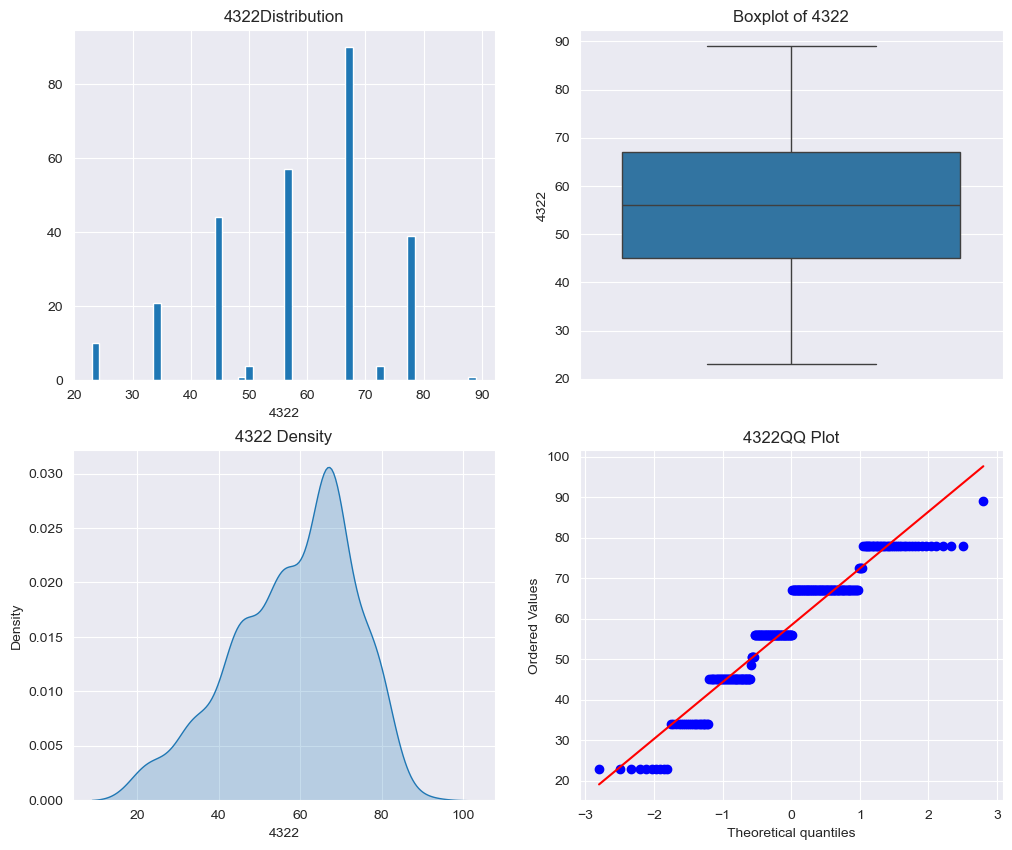

count   271.000
mean     58.740
std      14.757
min      23.000
25%      45.000
50%      56.000
75%      67.000
99%      78.000
max      89.000
Name: 4323, dtype: float64
********************************************


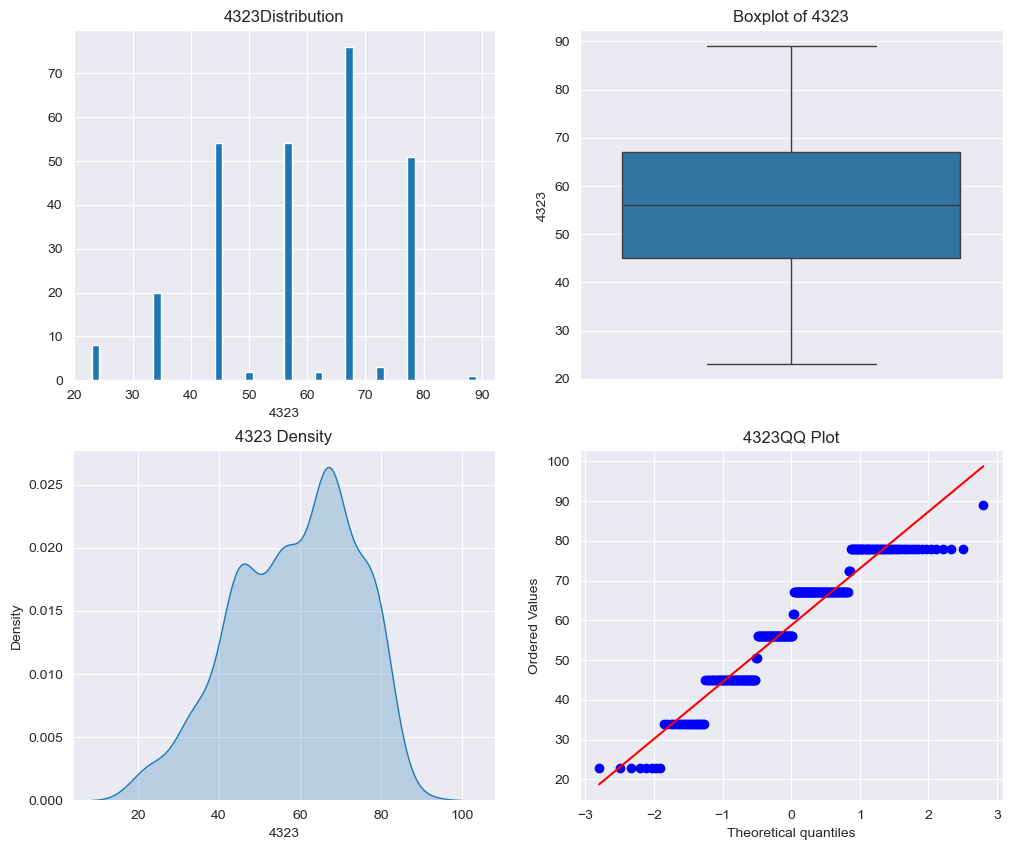

count   271.000
mean     56.947
std      14.749
min      12.000
25%      45.000
50%      61.500
75%      67.000
99%      78.000
max      89.000
Name: 4325, dtype: float64
********************************************


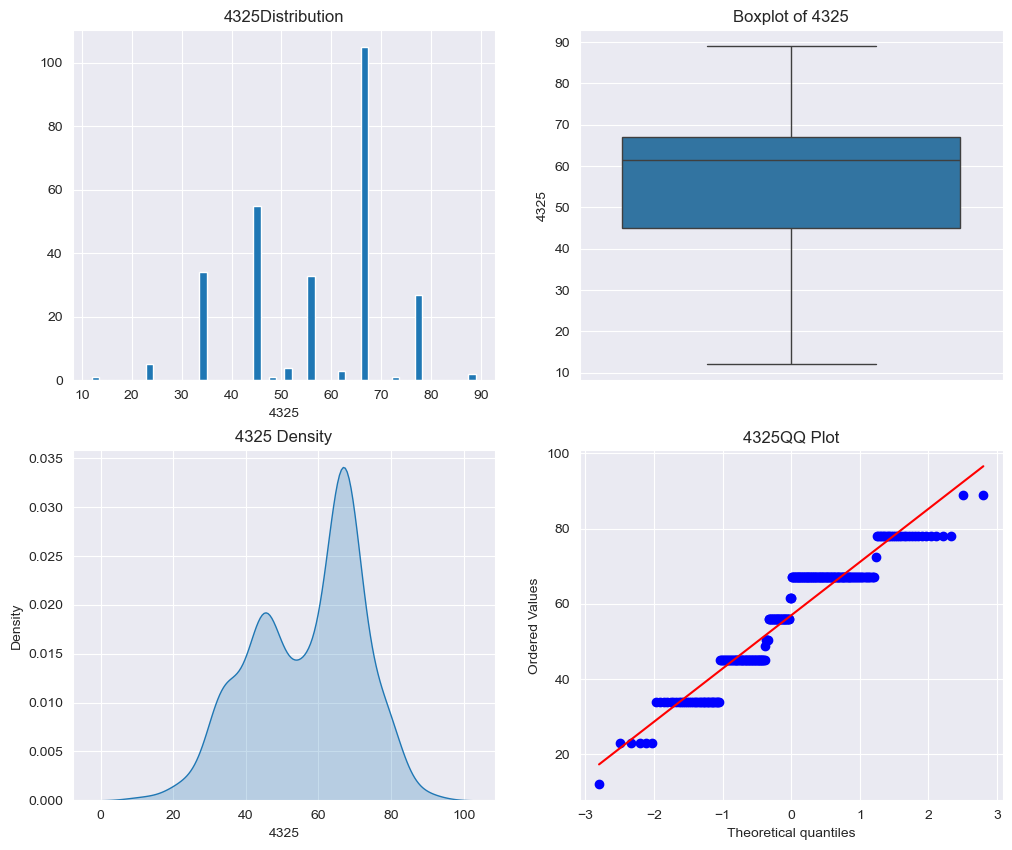

count   271.000
mean     56.325
std      14.800
min      23.000
25%      45.000
50%      61.500
75%      67.000
99%      78.000
max      89.000
Name: 4326, dtype: float64
********************************************


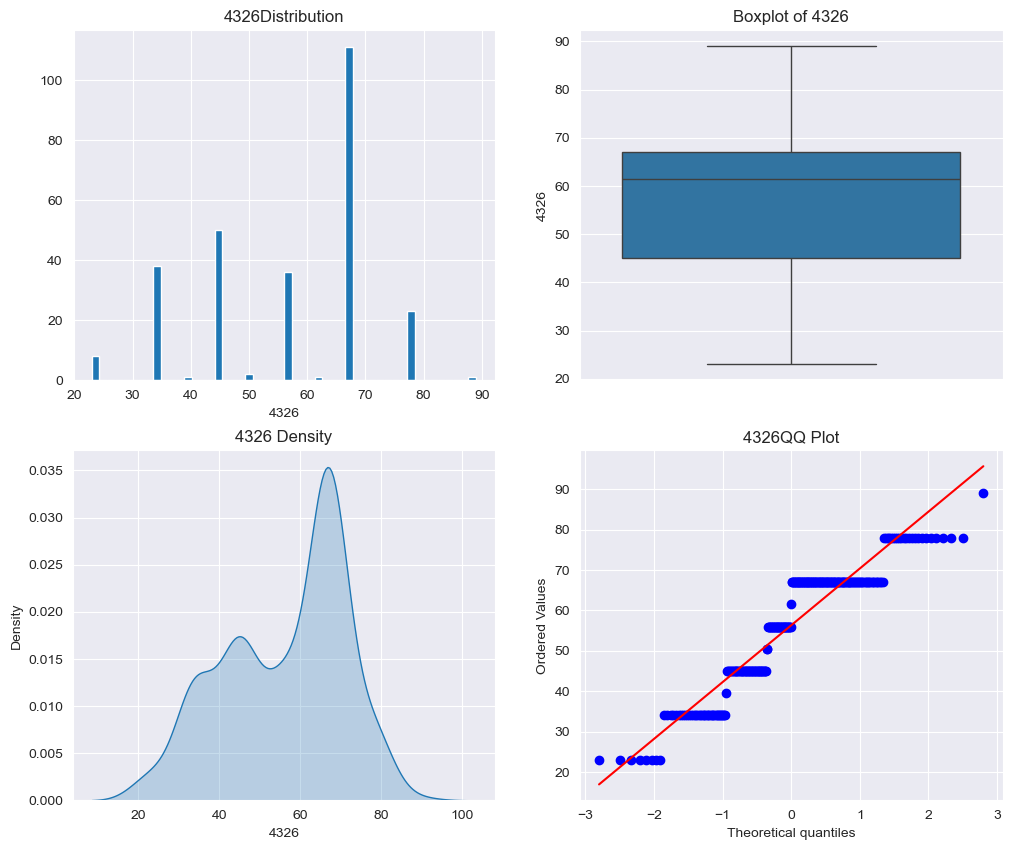

count   271.000
mean     56.521
std      14.522
min      23.000
25%      45.000
50%      56.000
75%      67.000
99%      78.000
max      78.000
Name: 4327, dtype: float64
********************************************


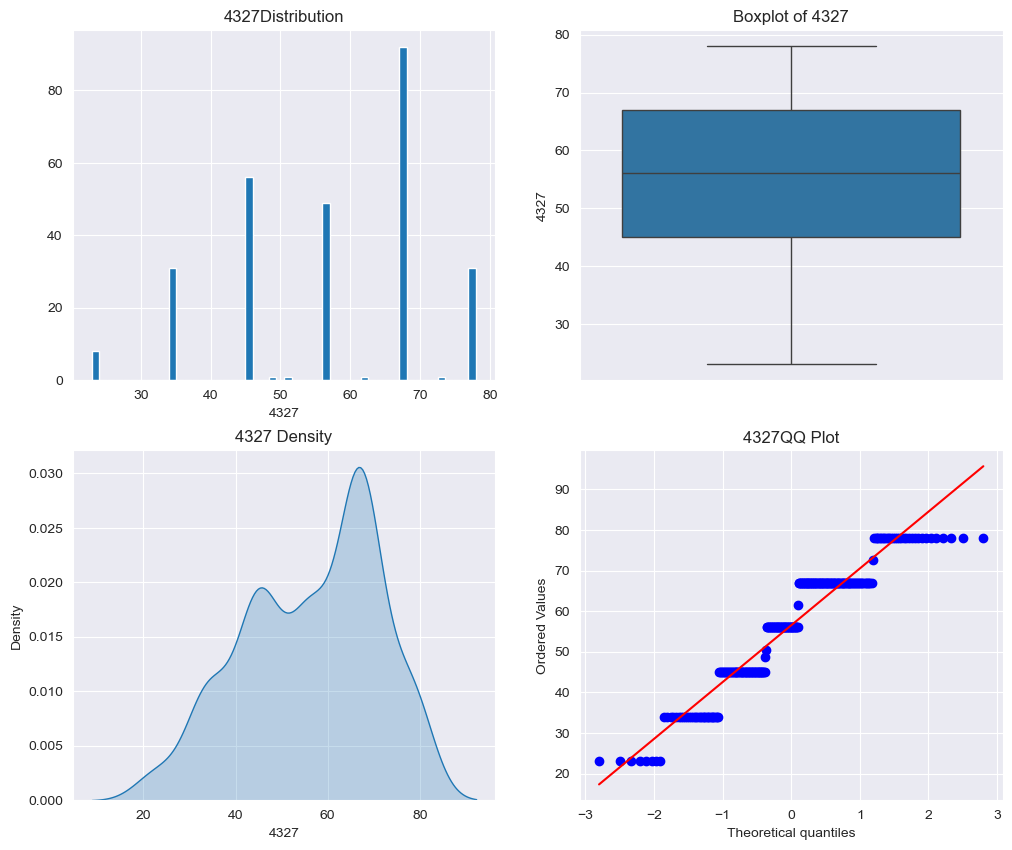

count   271.000
mean     59.565
std      18.434
min      12.000
25%      45.000
50%      67.000
75%      78.000
99%      78.000
max      89.000
Name: 4329, dtype: float64
********************************************


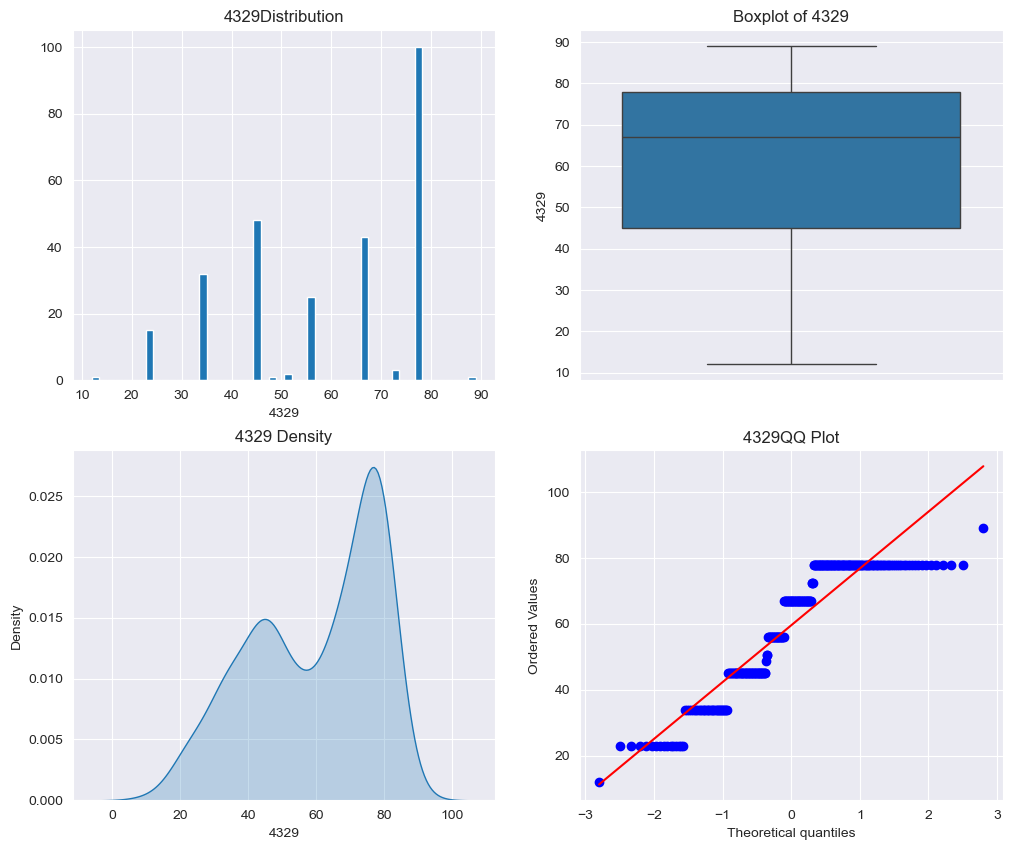

count   271.000
mean     56.771
std      14.077
min      23.000
25%      45.000
50%      61.500
75%      67.000
99%      78.000
max      89.000
Name: 4330, dtype: float64
********************************************


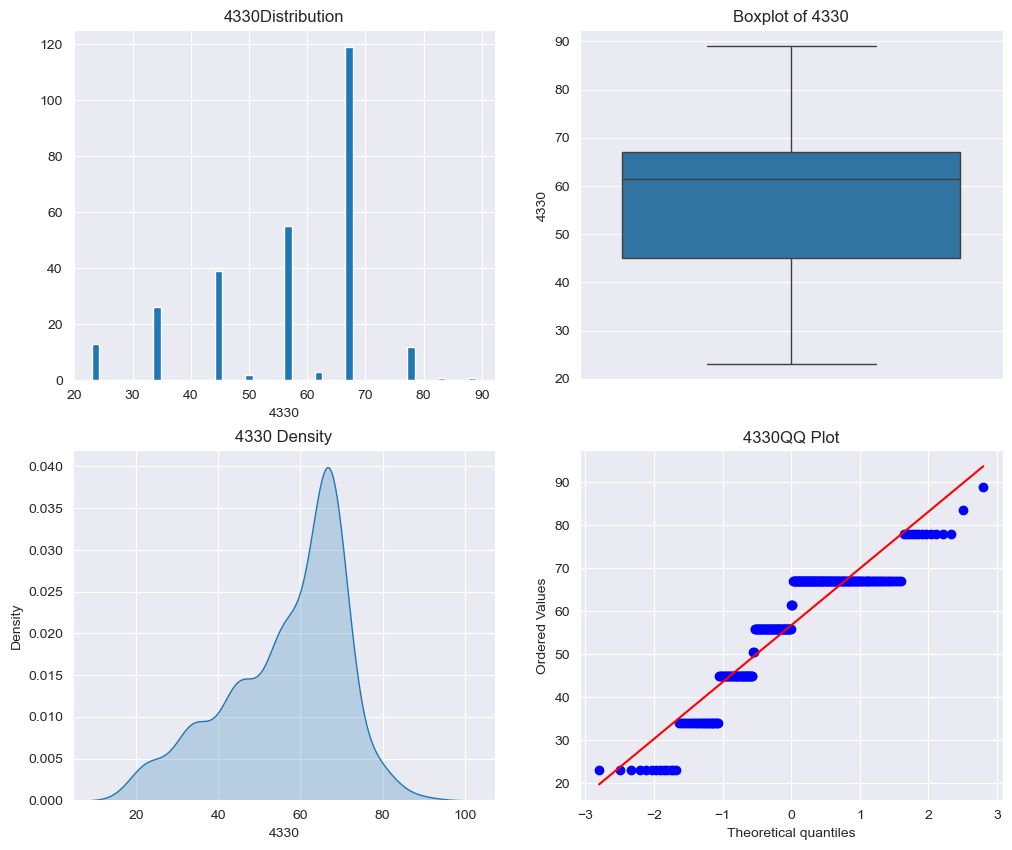

count   271.000
mean     57.657
std      13.542
min      23.000
25%      45.000
50%      61.500
75%      67.000
99%      78.000
max      89.000
Name: 4332, dtype: float64
********************************************


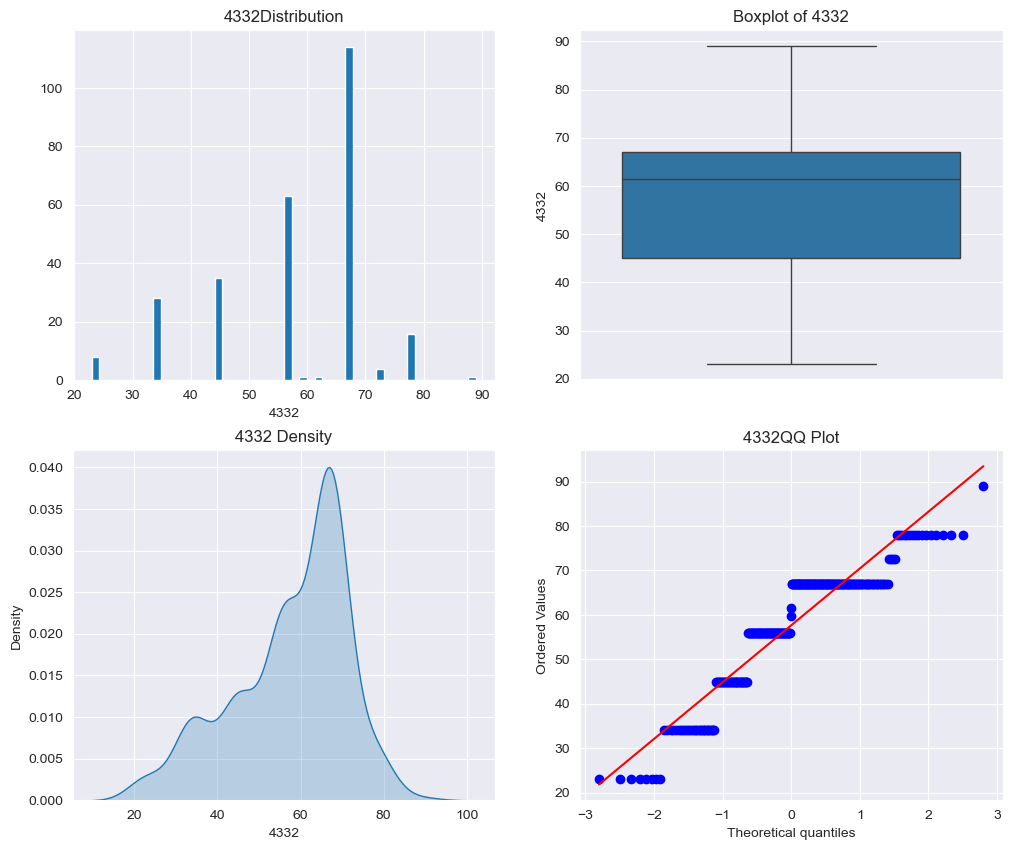

count   271.000
mean     59.498
std      16.370
min      23.000
25%      45.000
50%      67.000
75%      78.000
99%      78.000
max      78.000
Name: 4333, dtype: float64
********************************************


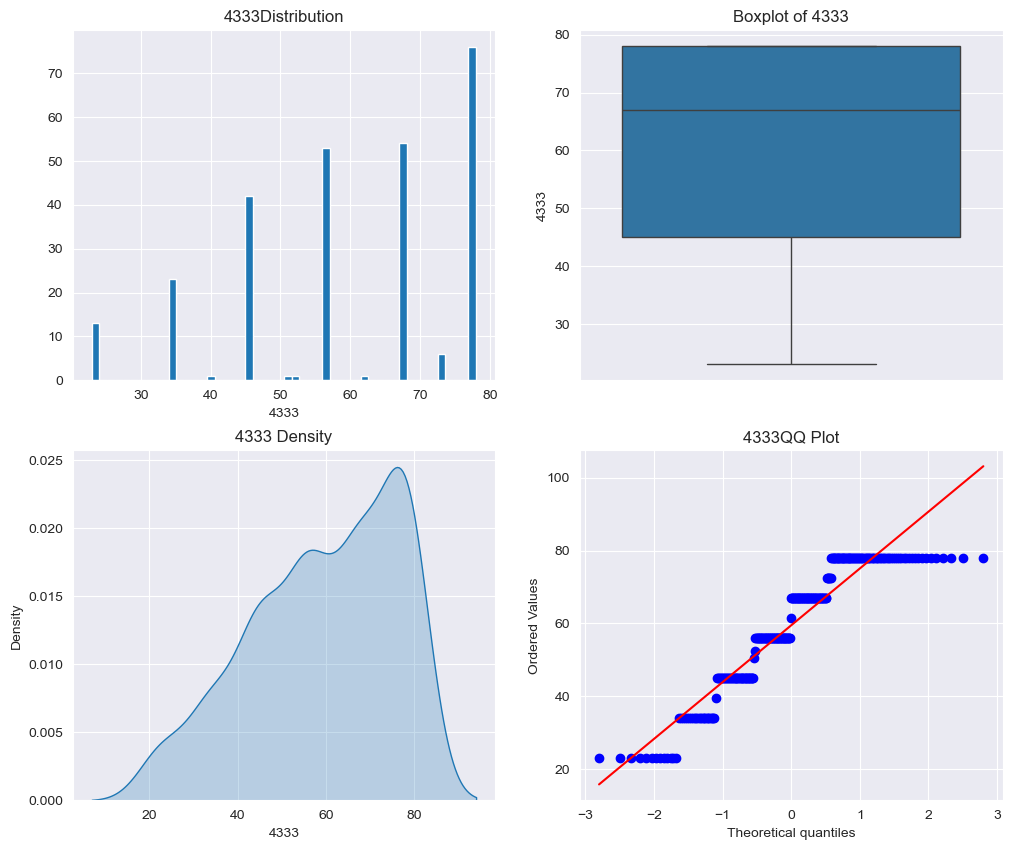

count   271.000
mean     50.818
std      16.269
min      12.000
25%      34.000
50%      56.000
75%      67.000
99%      78.000
max      89.000
Name: 4335, dtype: float64
********************************************


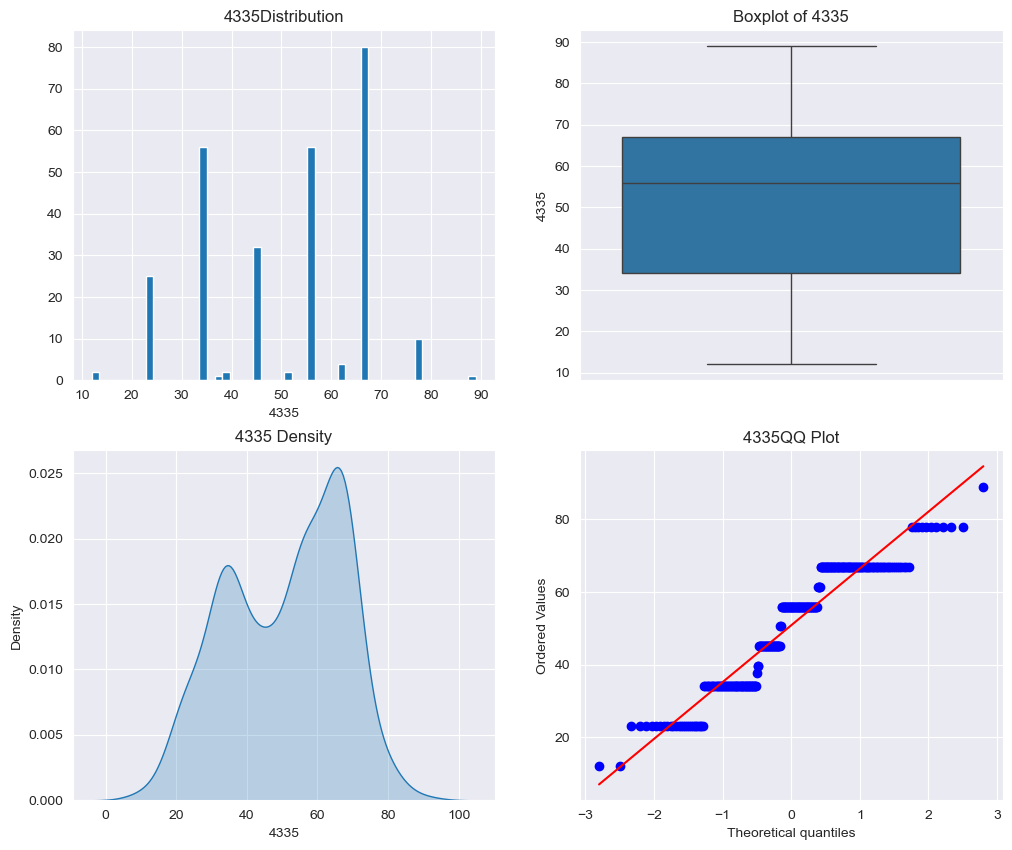

count   271.000
mean     57.116
std      15.671
min      23.000
25%      45.000
50%      56.000
75%      67.000
99%      78.000
max      78.000
Name: 4338, dtype: float64
********************************************


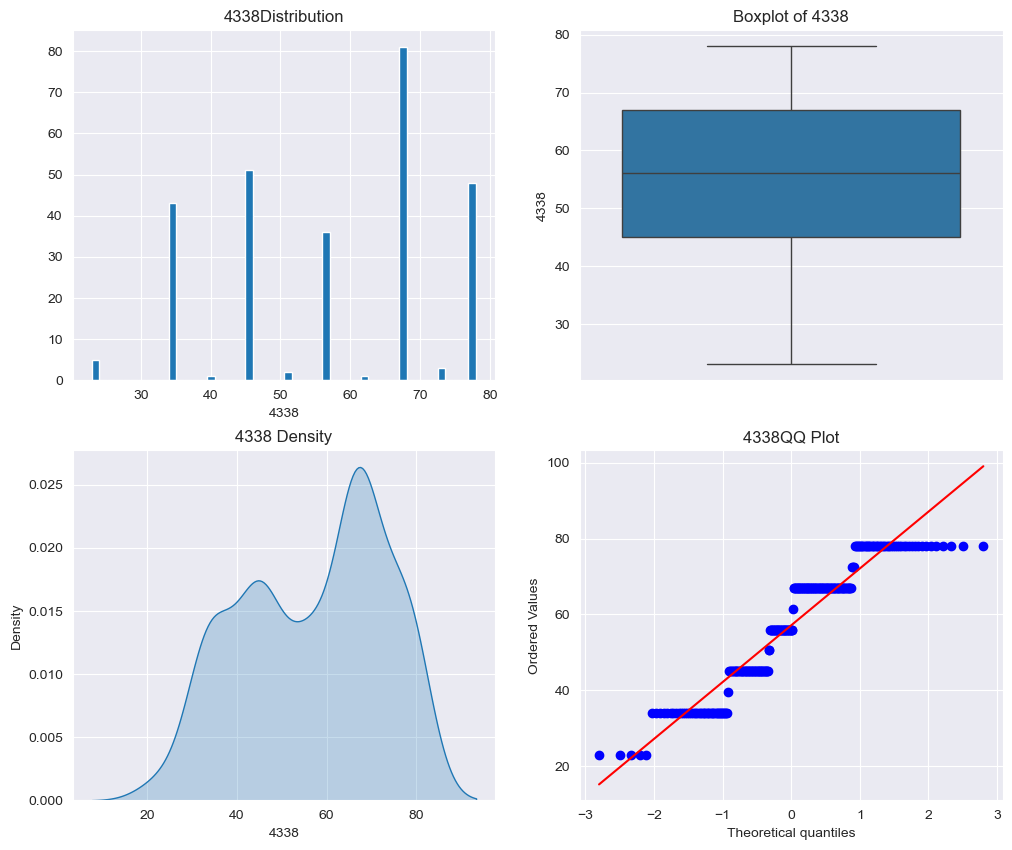

count   271.000
mean     54.505
std      14.894
min      23.000
25%      45.000
50%      56.000
75%      67.000
99%      78.000
max      89.000
Name: 4339, dtype: float64
********************************************


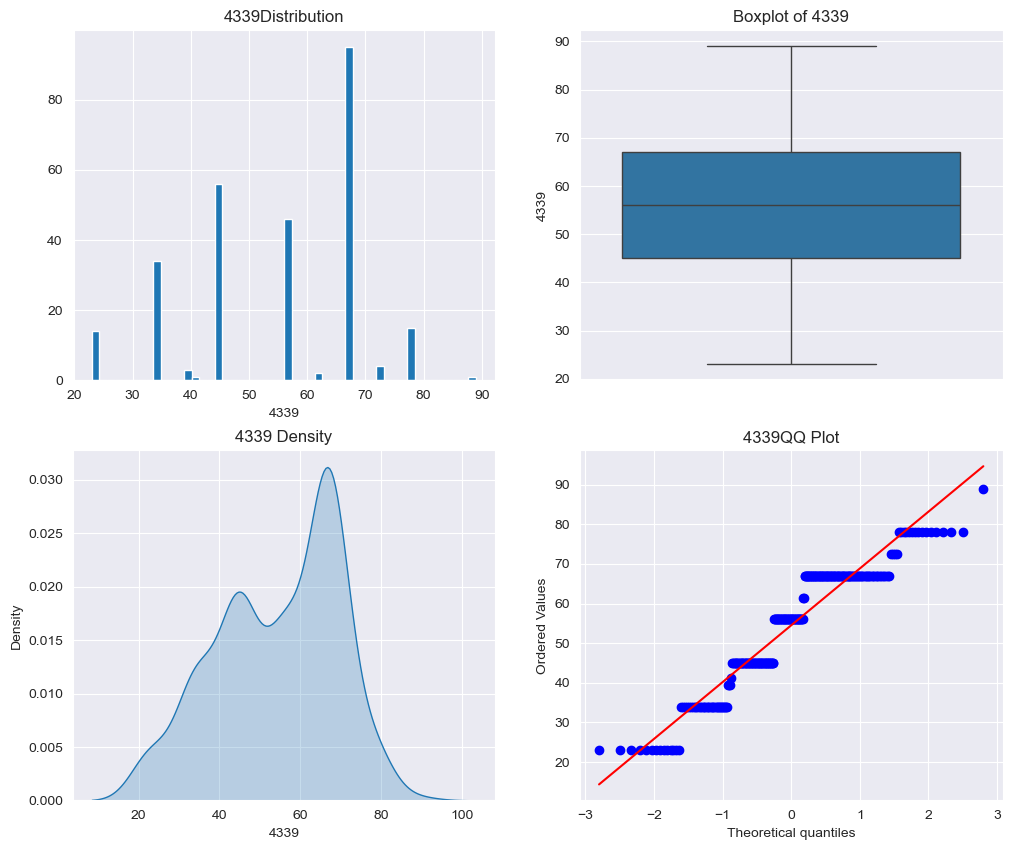

count   271.000
mean     53.199
std      15.161
min      12.000
25%      45.000
50%      56.000
75%      67.000
99%      78.000
max      78.000
Name: 4340, dtype: float64
********************************************


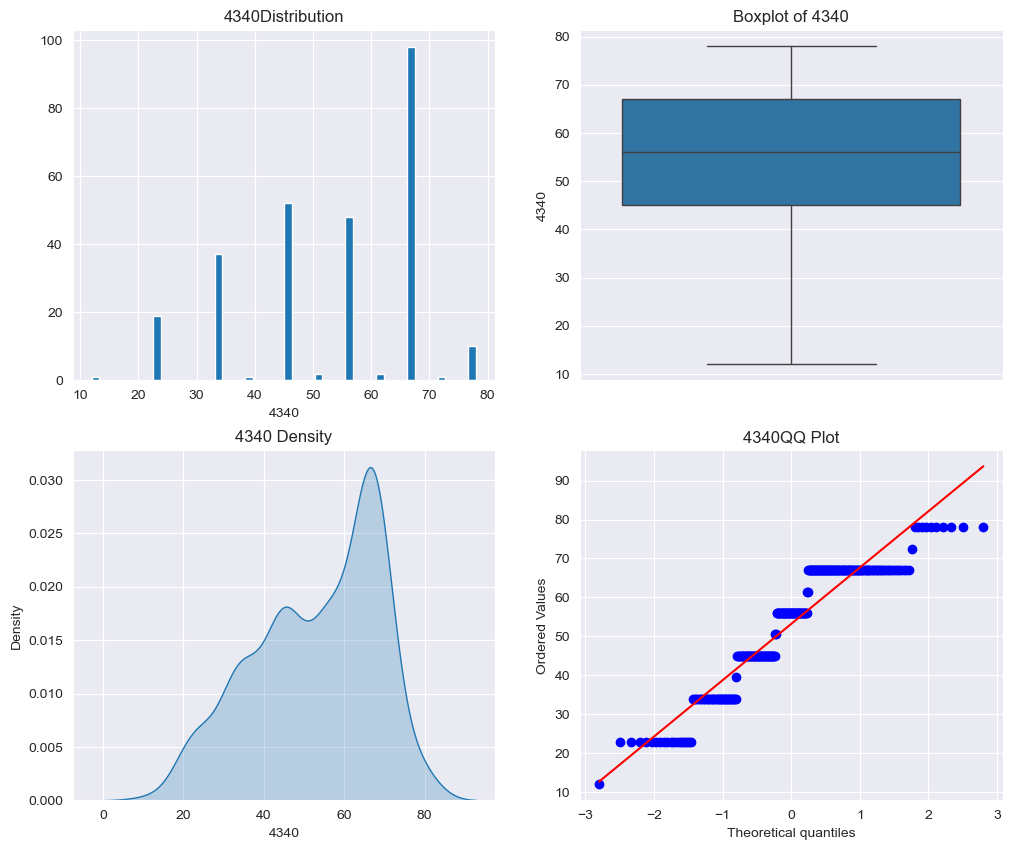

count   271.000
mean     55.195
std      14.795
min      23.000
25%      45.000
50%      56.000
75%      67.000
99%      78.000
max      89.000
Name: 4341, dtype: float64
********************************************


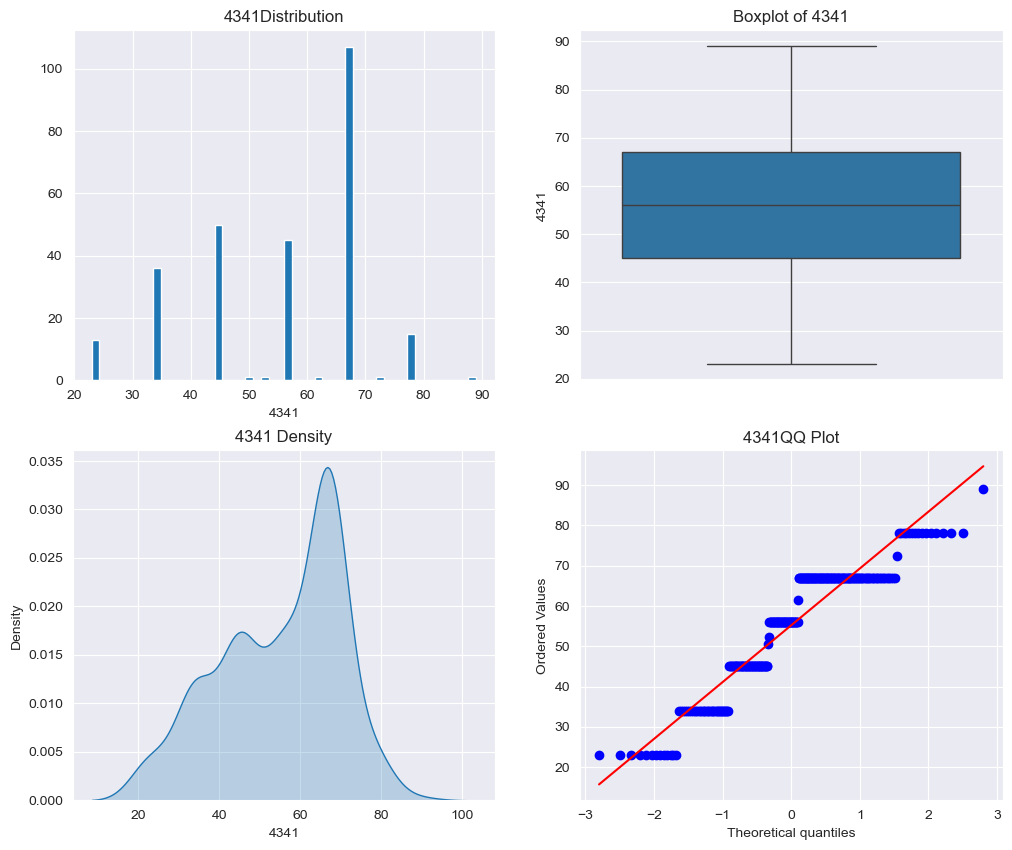

count   271.000
mean     58.361
std      14.718
min      23.000
25%      45.000
50%      67.000
75%      67.000
99%      78.000
max      89.000
Name: 4342, dtype: float64
********************************************


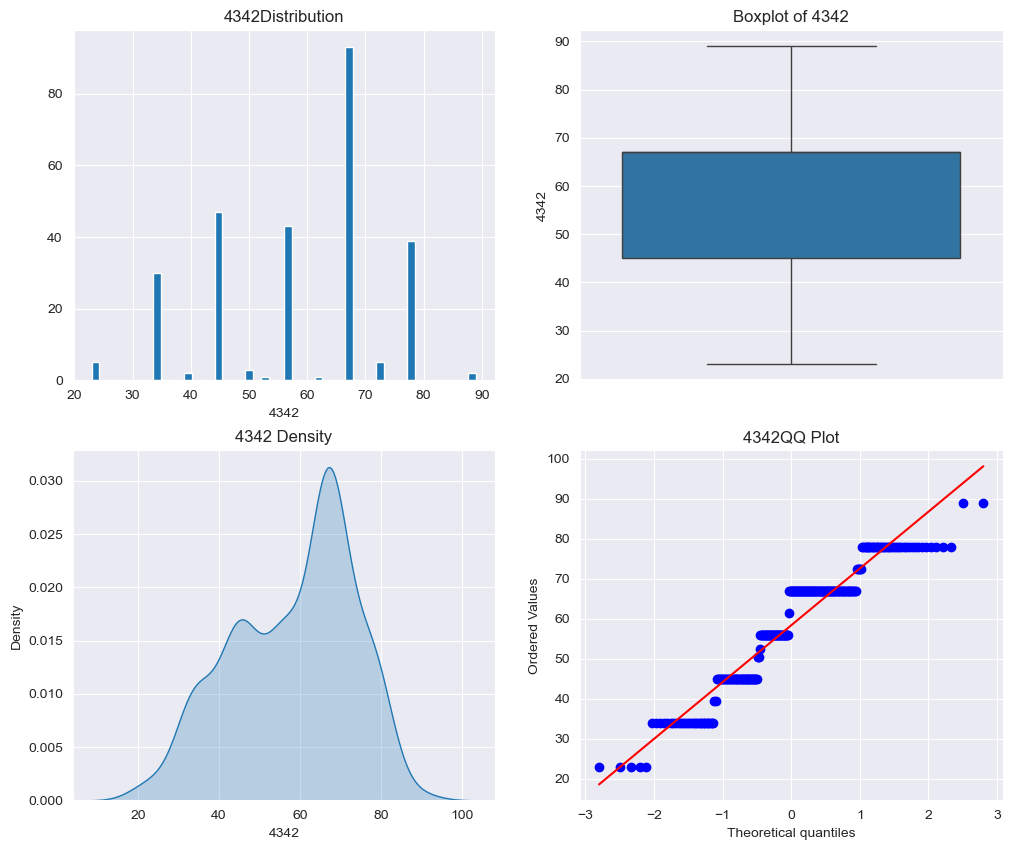

count   271.000
mean     46.387
std      16.790
min      12.000
25%      34.000
50%      45.000
75%      56.000
99%      74.150
max      89.000
Name: 4343, dtype: float64
********************************************


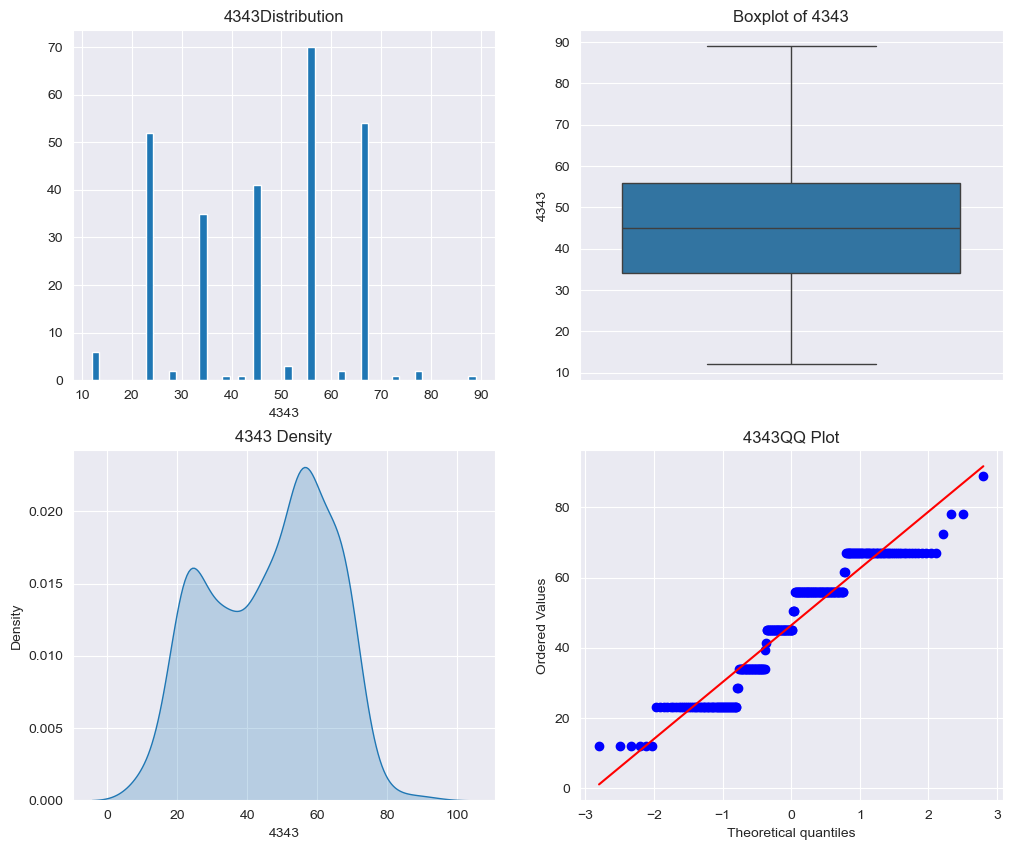

count   271.000
mean     43.349
std      16.909
min      12.000
25%      23.000
50%      45.000
75%      56.000
99%      78.000
max     100.000
Name: 4344, dtype: float64
********************************************


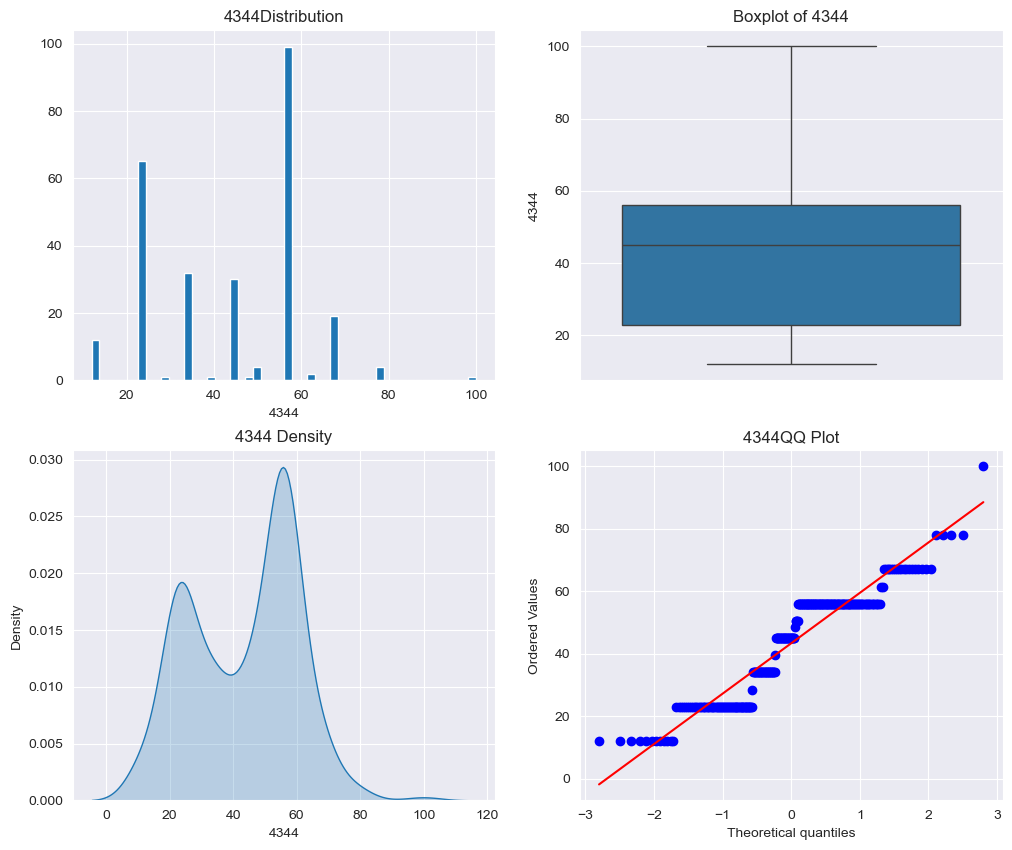

count   271.000
mean     55.317
std      15.768
min      23.000
25%      45.000
50%      56.000
75%      67.000
99%      78.000
max      83.500
Name: 4345, dtype: float64
********************************************


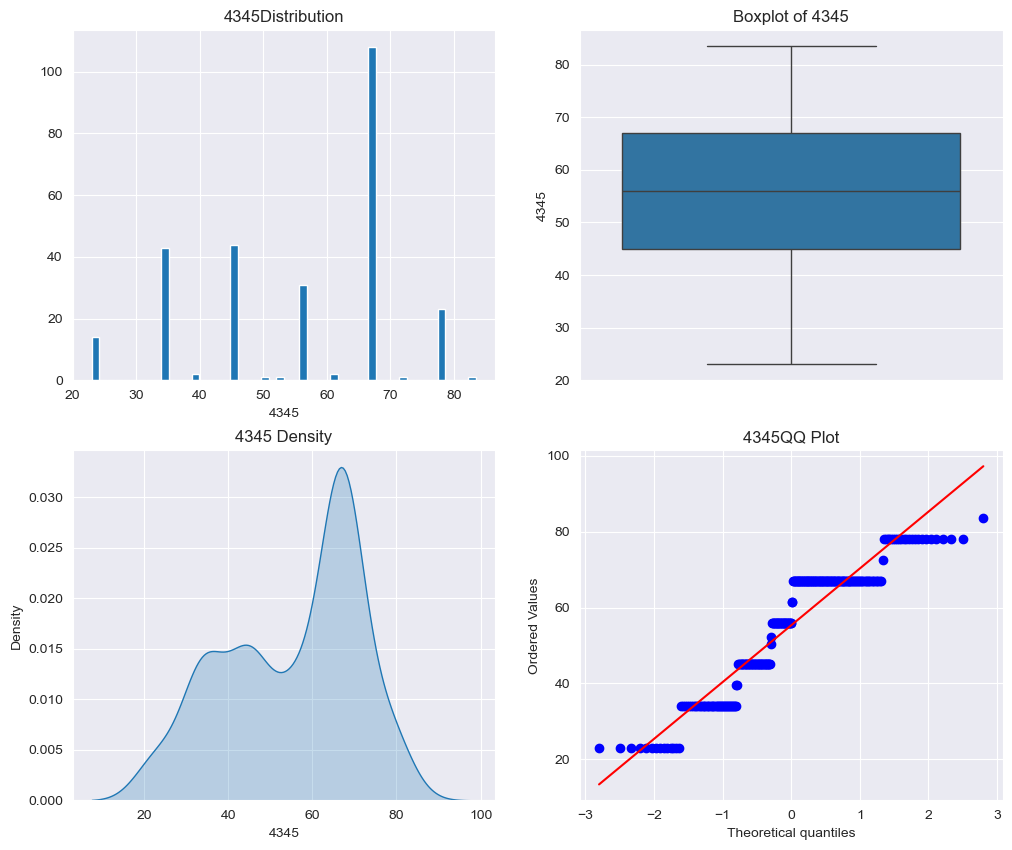

count   271.000
mean     51.569
std      17.592
min      12.000
25%      34.000
50%      56.000
75%      67.000
99%      78.000
max      89.000
Name: 4348, dtype: float64
********************************************


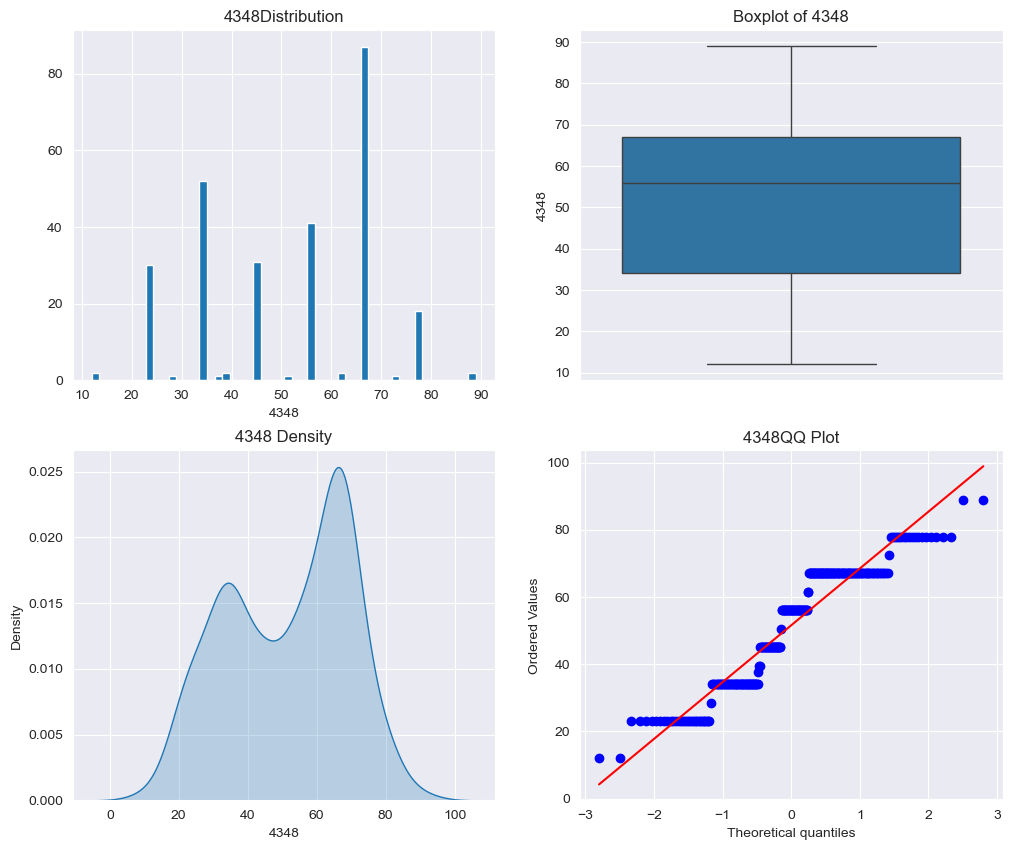

count   271.000
mean     45.237
std      16.095
min      12.000
25%      34.000
50%      45.000
75%      56.000
99%      78.000
max      89.000
Name: 4349, dtype: float64
********************************************


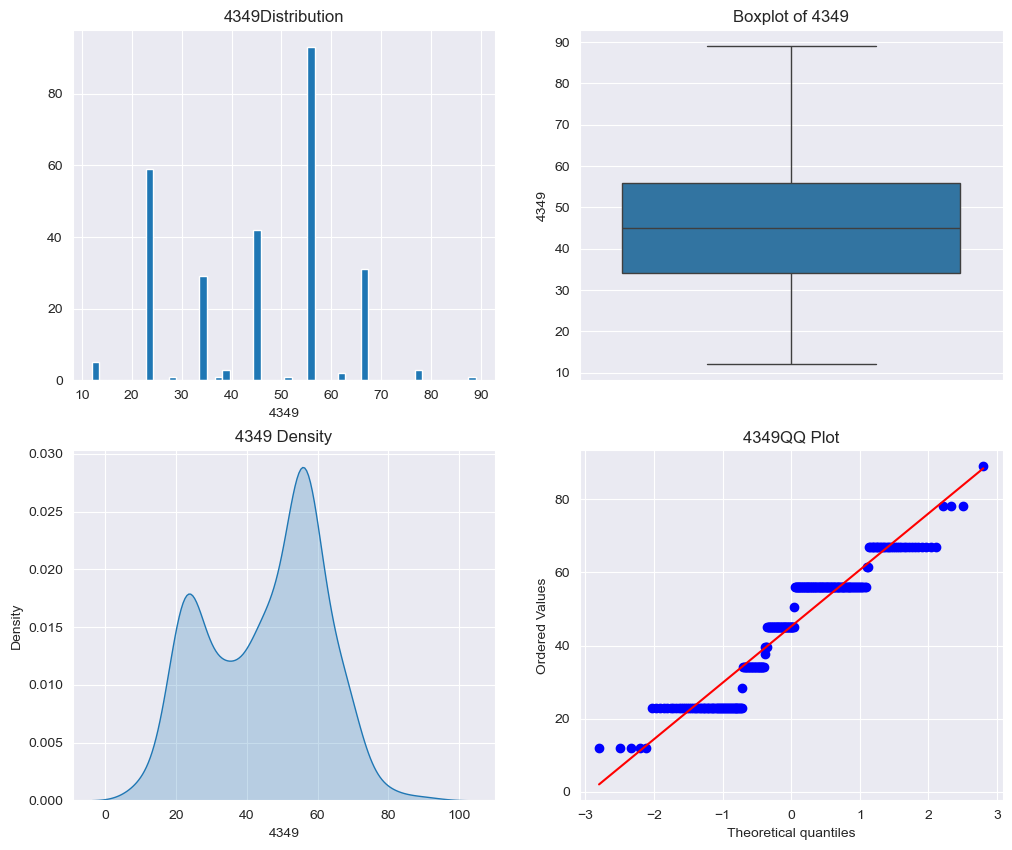

count   271.000
mean     54.897
std      14.303
min      12.000
25%      45.000
50%      56.000
75%      67.000
99%      78.000
max      78.000
Name: 4350, dtype: float64
********************************************


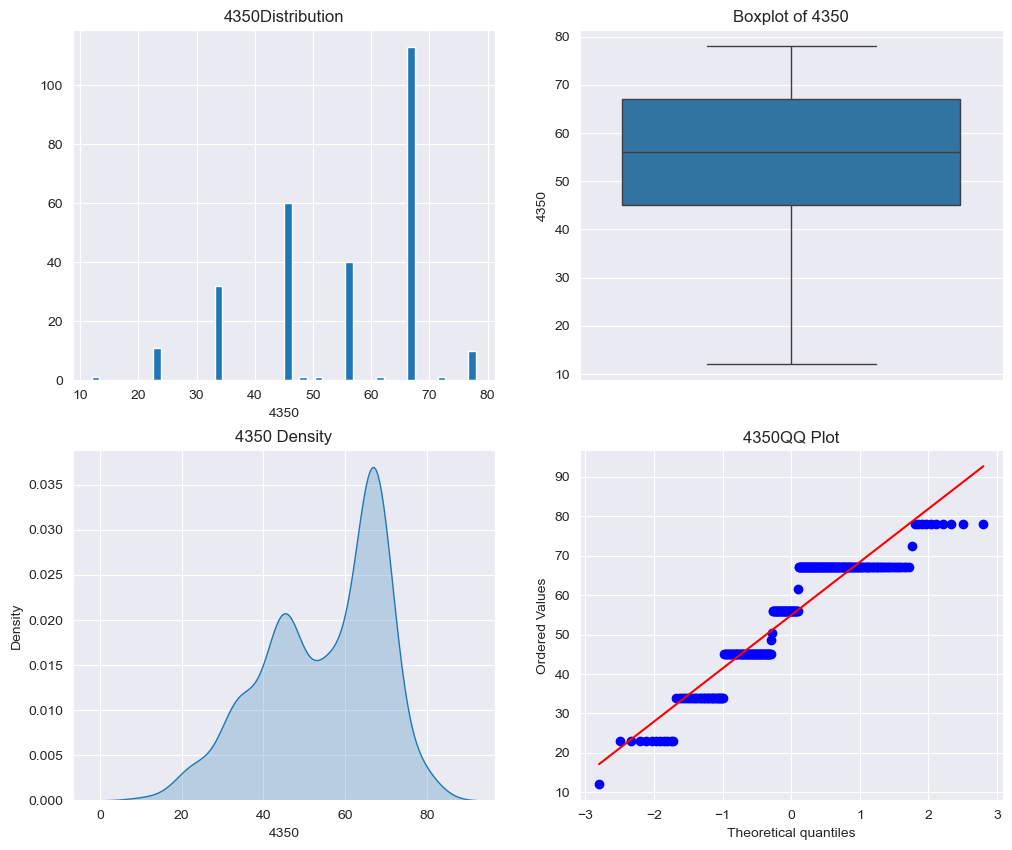

count   271.000
mean     56.737
std      14.344
min      12.000
25%      45.000
50%      56.000
75%      67.000
99%      78.000
max     100.000
Name: 4351, dtype: float64
********************************************


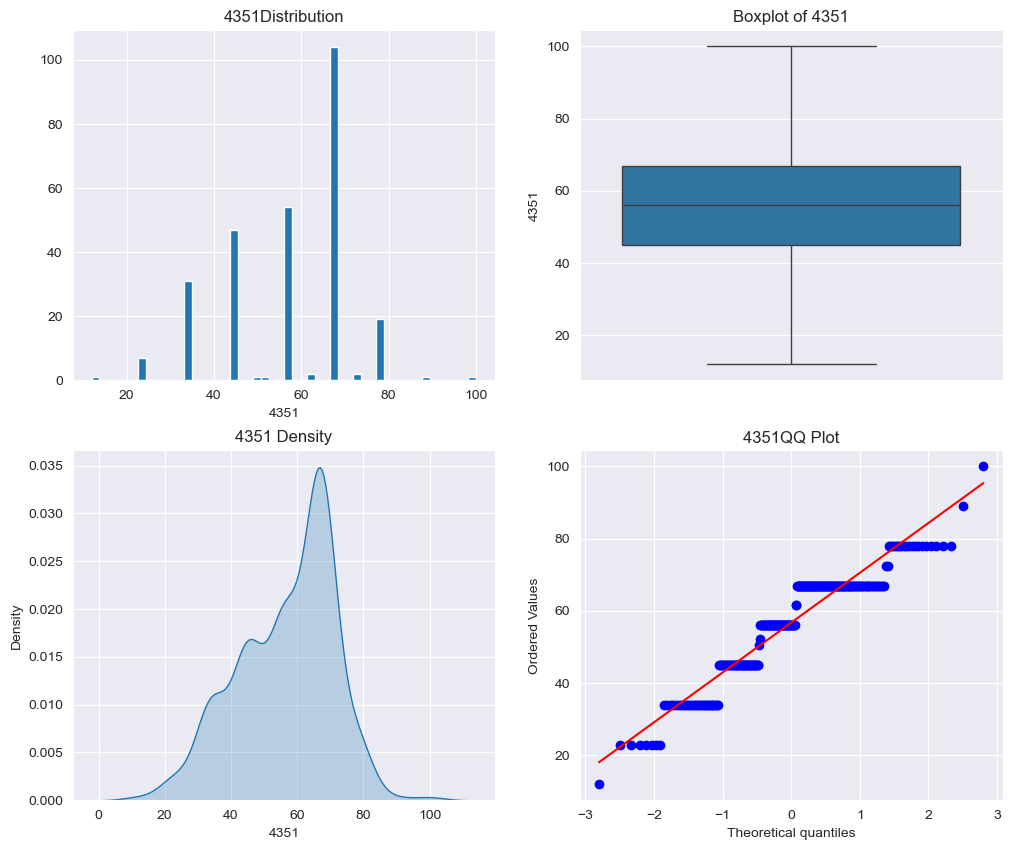

count   271.000
mean     54.187
std      15.777
min      12.000
25%      45.000
50%      56.000
75%      67.000
99%      78.000
max      78.000
Name: 4353, dtype: float64
********************************************


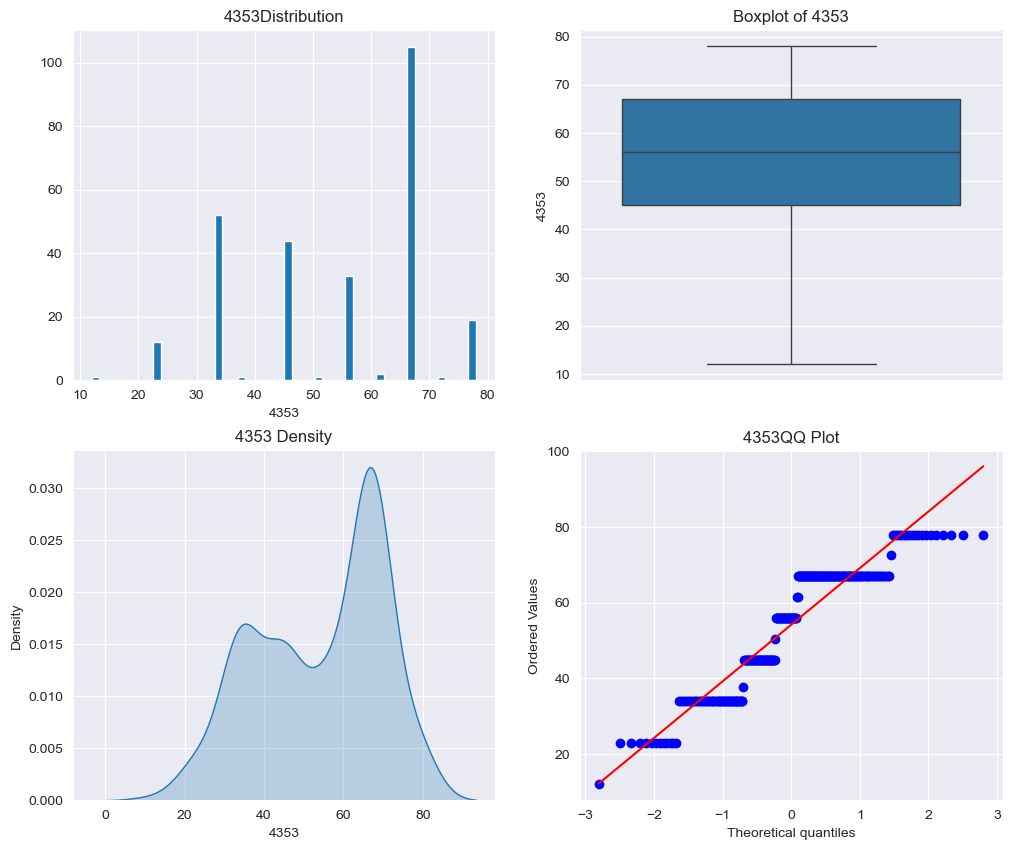

count   271.000
mean     59.450
std      17.653
min      12.000
25%      45.000
50%      56.000
75%      78.000
99%      78.000
max      78.000
Name: 4354, dtype: float64
********************************************


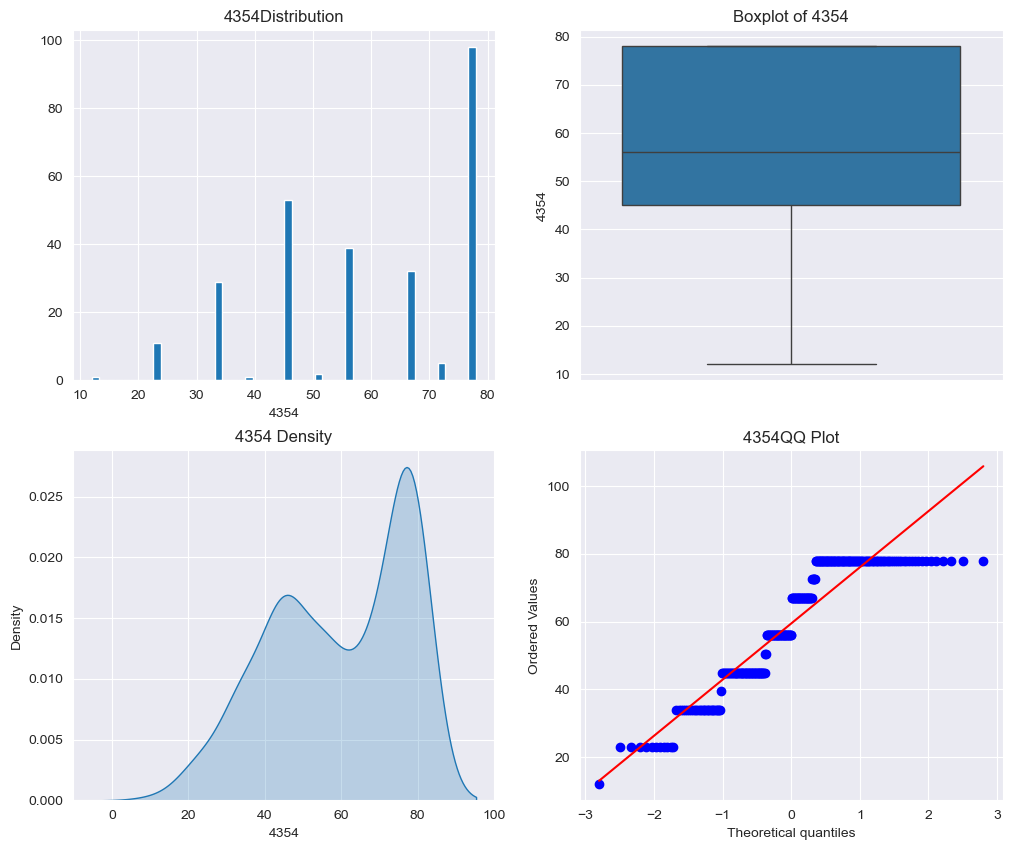

count   271.000
mean     57.745
std      14.677
min      12.000
25%      45.000
50%      56.000
75%      67.000
99%      78.000
max      89.000
Name: 4355, dtype: float64
********************************************


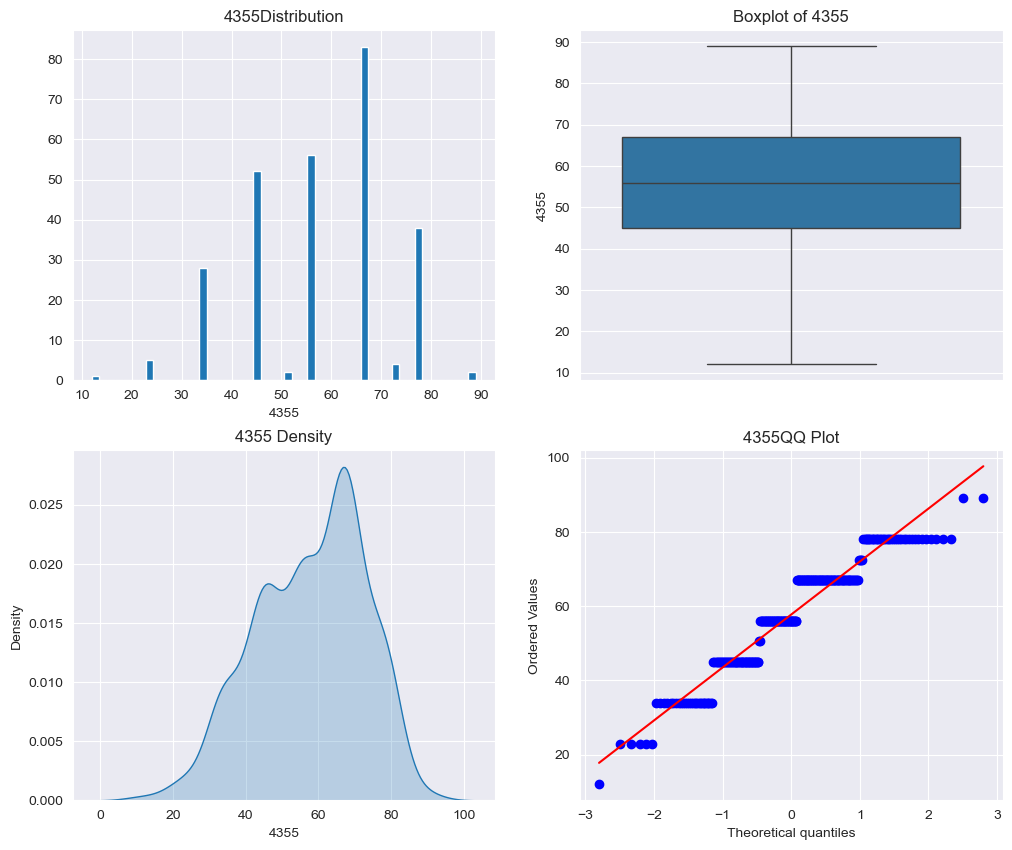

count   271.000
mean     52.956
std      15.379
min      23.000
25%      36.750
50%      56.000
75%      67.000
99%      78.000
max      78.000
Name: 4356, dtype: float64
********************************************


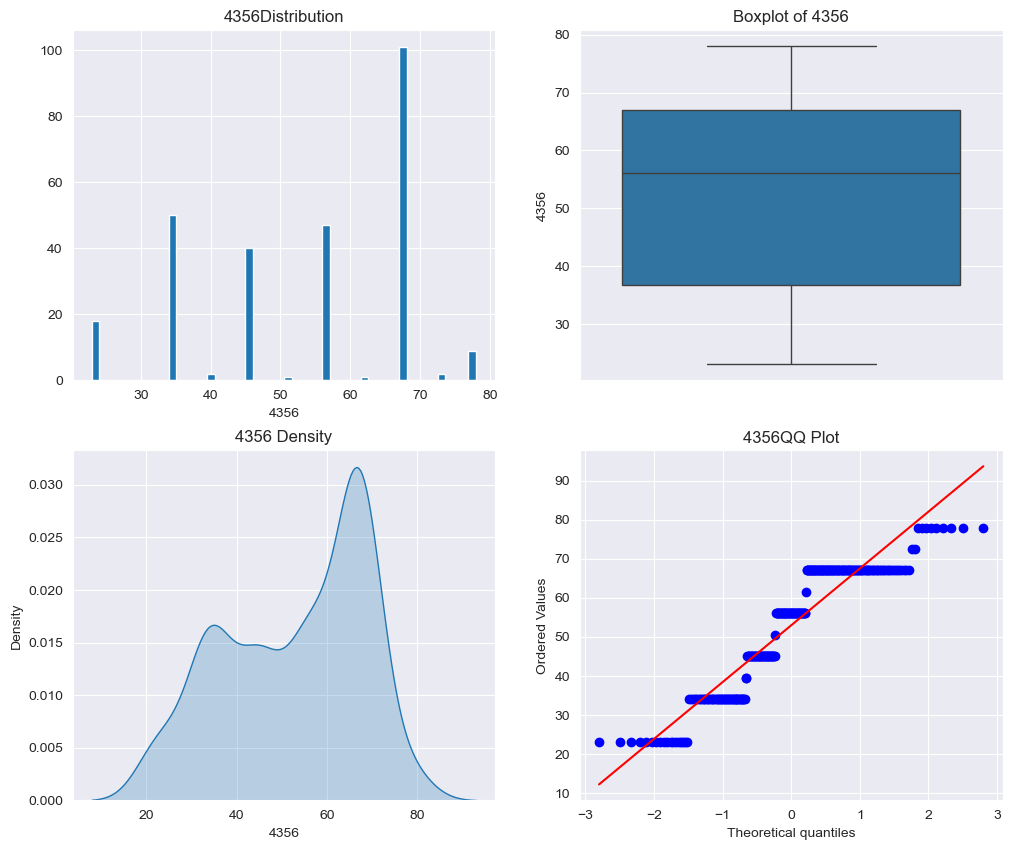

count   271.000
mean     58.334
std      16.392
min       1.000
25%      45.000
50%      67.000
75%      67.000
99%      89.000
max     100.000
Name: 4407, dtype: float64
********************************************


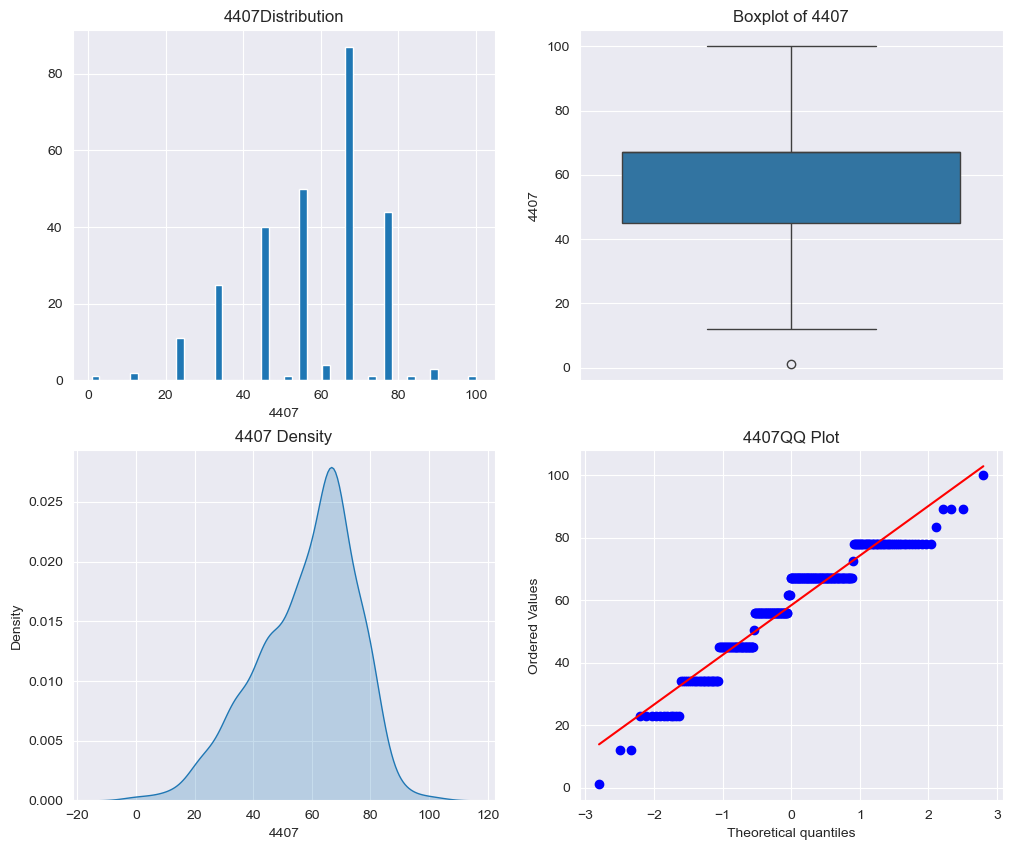

count   271.000
mean     56.764
std      15.335
min      12.000
25%      45.000
50%      56.000
75%      67.000
99%      78.000
max      89.000
Name: 4408, dtype: float64
********************************************


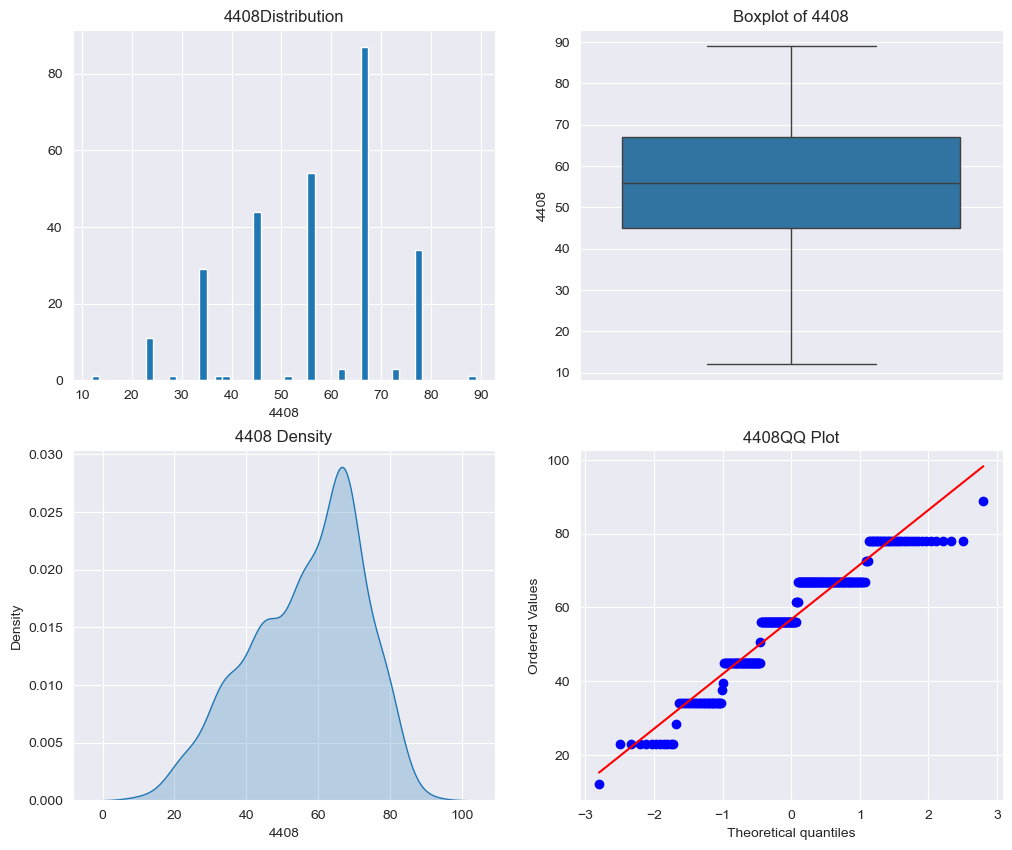

count   271.000
mean     60.296
std      17.028
min      23.000
25%      45.000
50%      61.500
75%      78.000
99%      78.000
max      89.000
Name: 4426, dtype: float64
********************************************


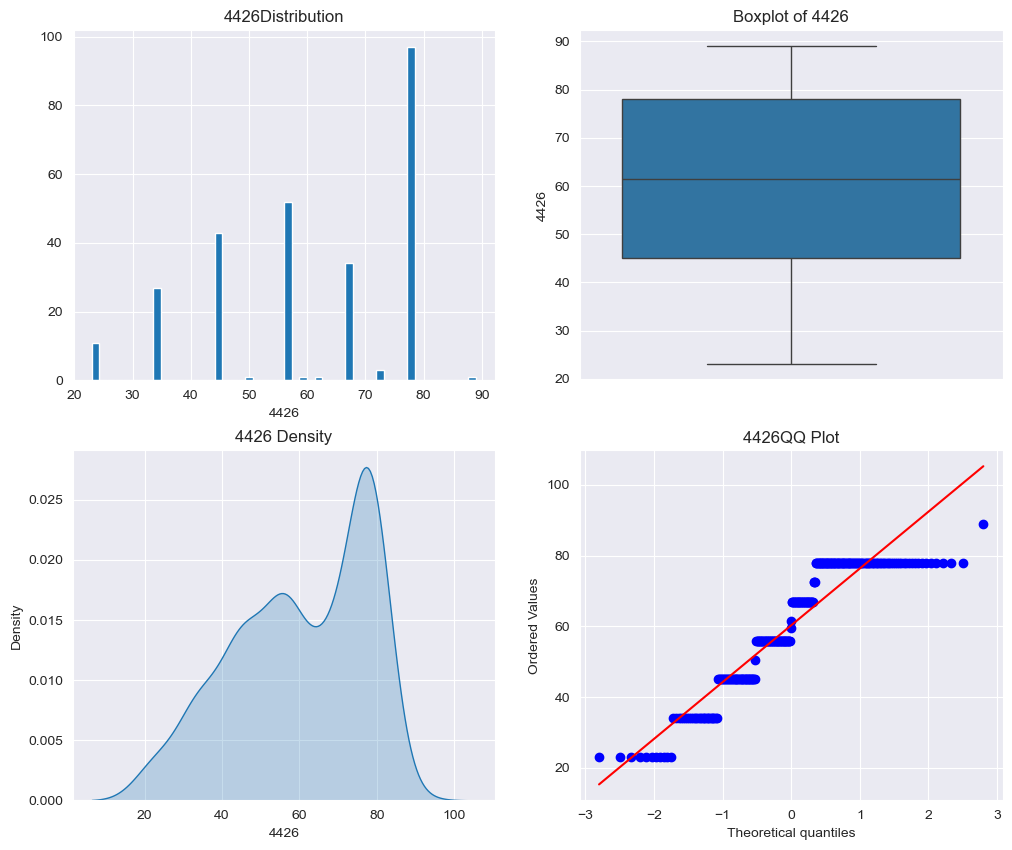

In [27]:
for col in num_cols:
    num_summary(pivot_df, col, plot = True)

#### 2.2 Label Encoding İşlemi

In [28]:
# LE fonksiyonunu kullanarak “potential_label” kategorilerini (average, highlighted) sayısal olarak ifade edilmesi
pivot_df['potential_label'] = LabelEncoder().fit_transform(pivot_df['potential_label'])

In [29]:
pivot_df

attribute_id  player_id  position_id  potential_label   4322   4323   4324  \
0               1355710            7                0 50.500 50.500 34.000   
1               1356362            9                0 67.000 67.000 67.000   
2               1356375            3                0 67.000 67.000 67.000   
3               1356375            4                0 67.000 78.000 67.000   
4               1356411            9                0 67.000 67.000 78.000   
..                  ...          ...              ...    ...    ...    ...   
266             1907347            5                0 67.000 78.000 78.000   
267             1907347            6                0 67.000 67.000 67.000   
268             1909532           10                0 56.000 45.000 45.000   
269             1909724            2                1 78.000 78.000 78.000   
270             1909728            7                1 78.000 67.000 67.000   

attribute_id   4325   4326   4327   4328   4329   4330   4332   4333   4335  \
0            50.500 45.000 45.000 45.000 45.000 50.500 56.000 39.500 34.000   
1            67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000   
2            67.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000 56.000   
3            67.000 67.000 78.000 78.000 78.000 56.000 67.000 67.000 67.000   
4            78.000 67.000 67.000 67.000 67.000 89.000 78.000 67.000 67.000   
..              ...    ...    ...    ...    ...    ...    ...    ...    ...   
266          56.000 78.000 67.000 78.000 67.000 56.000 78.000 78.000 56.000   
267          67.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000 56.000   
268          45.000 56.000 56.000 56.000 56.000 23.000 23.000 34.000 45.000   
269          78.000 78.000 78.000 78.000 78.000 67.000 67.000 78.000 78.000   
270          78.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000 67.000   

attribute_id   4338   4339   4340   4341   4342   4343   4344   4345   4348  \
0            39.500 39.500 45.000 45.000 50.500 28.500 23.000 39.500 28.500   
1            67.000 67.000 67.000 67.000 67.000 67.000 56.000 67.000 67.000   
2            67.000 67.000 67.000 67.000 67.000 56.000 56.000 67.000 67.000   
3            78.000 78.000 56.000 67.000 67.000 45.000 45.000 56.000 67.000   
4            67.000 56.000 56.000 67.000 78.000 56.000 56.000 67.000 56.000   
..              ...    ...    ...    ...    ...    ...    ...    ...    ...   
266          67.000 67.000 78.000 56.000 67.000 56.000 56.000 67.000 78.000   
267          67.000 67.000 67.000 67.000 78.000 67.000 56.000 67.000 67.000   
268          56.000 34.000 23.000 45.000 45.000 23.000 23.000 34.000 23.000   
269          78.000 67.000 78.000 67.000 78.000 56.000 56.000 78.000 78.000   
270          78.000 67.000 67.000 78.000 78.000 67.000 56.000 78.000 67.000   

attribute_id   4349   4350   4351   4352   4353   4354   4355   4356   4357  \
0            28.500 45.000 50.500 56.000 34.000 39.500 50.500 34.000 34.000   
1            56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000   
2            56.000 56.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000   
3            67.000 67.000 67.000 78.000 67.000 67.000 67.000 56.000 67.000   
4            67.000 56.000 67.000 67.000 56.000 67.000 67.000 56.000 67.000   
..              ...    ...    ...    ...    ...    ...    ...    ...    ...   
266          89.000 67.000 78.000 67.000 67.000 67.000 67.000 56.000 67.000   
267          67.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000   
268          23.000 34.000 23.000 45.000 45.000 56.000 34.000 34.000 56.000   
269          67.000 78.000 78.000 78.000 78.000 78.000 67.000 67.000 67.000   
270          56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000   

attribute_id   4407   4408   4423   4426  
0            56.000 34.000 34.000 56.000  
1            67.000 67.000 56.000 78.000  
2            67.000 67.000 56.000 78.000  
3            56.000 67.000 45.000 56.000  
4

In [30]:
cat_cols, num_cols, cat_but_car = grab_col_name(pivot_df)

Observations: 271
Variables: 37
cat_cols: 7
num_cols: 30
cat_but_car: 0


In [31]:
# Numerik değişkenlerde player_id kaldırılması
num_cols.remove('player_id')

In [32]:
specific_num_cols = ['4324', '4328', '4352', '4423'] # Önemli sayısal değişkenler

for col in specific_num_cols:
    if col in cat_cols:
        cat_cols.remove(col)
        num_cols.append(col)

num_cols

['4322',
 '4323',
 '4325',
 '4326',
 '4327',
 '4329',
 '4330',
 '4332',
 '4333',
 '4335',
 '4338',
 '4339',
 '4340',
 '4341',
 '4342',
 '4343',
 '4344',
 '4345',
 '4348',
 '4349',
 '4350',
 '4351',
 '4353',
 '4354',
 '4355',
 '4356',
 '4407',
 '4408',
 '4426',
 '4324',
 '4328',
 '4352',
 '4423']

In [33]:
pivot_df[num_cols] # sayısal değişkenlerin kontrolü

attribute_id   4322   4323   4325   4326   4327   4329   4330   4332   4333  \
0            50.500 50.500 50.500 45.000 45.000 45.000 50.500 56.000 39.500   
1            67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000   
2            67.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000   
3            67.000 78.000 67.000 67.000 78.000 78.000 56.000 67.000 67.000   
4            67.000 67.000 78.000 67.000 67.000 67.000 89.000 78.000 67.000   
..              ...    ...    ...    ...    ...    ...    ...    ...    ...   
266          67.000 78.000 56.000 78.000 67.000 67.000 56.000 78.000 78.000   
267          67.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000   
268          56.000 45.000 45.000 56.000 56.000 56.000 23.000 23.000 34.000   
269          78.000 78.000 78.000 78.000 78.000 78.000 67.000 67.000 78.000   
270          78.000 67.000 78.000 67.000 67.000 78.000 67.000 67.000 78.000   

attribute_id   4335   4338   4339   4340   4341   4342   4343   4344   4345  \
0            34.000 39.500 39.500 45.000 45.000 50.500 28.500 23.000 39.500   
1            67.000 67.000 67.000 67.000 67.000 67.000 67.000 56.000 67.000   
2            56.000 67.000 67.000 67.000 67.000 67.000 56.000 56.000 67.000   
3            67.000 78.000 78.000 56.000 67.000 67.000 45.000 45.000 56.000   
4            67.000 67.000 56.000 56.000 67.000 78.000 56.000 56.000 67.000   
..              ...    ...    ...    ...    ...    ...    ...    ...    ...   
266          56.000 67.000 67.000 78.000 56.000 67.000 56.000 56.000 67.000   
267          56.000 67.000 67.000 67.000 67.000 78.000 67.000 56.000 67.000   
268          45.000 56.000 34.000 23.000 45.000 45.000 23.000 23.000 34.000   
269          78.000 78.000 67.000 78.000 67.000 78.000 56.000 56.000 78.000   
270          67.000 78.000 67.000 67.000 78.000 78.000 67.000 56.000 78.000   

attribute_id   4348   4349   4350   4351   4353   4354   4355   4356   4407  \
0            28.500 28.500 45.000 50.500 34.000 39.500 50.500 34.000 56.000   
1            67.000 56.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000   
2            67.000 56.000 56.000 67.000 67.000 78.000 67.000 67.000 67.000   
3            67.000 67.000 67.000 67.000 67.000 67.000 67.000 56.000 56.000   
4            56.000 67.000 56.000 67.000 56.000 67.000 67.000 56.000 89.000   
..              ...    ...    ...    ...    ...    ...    ...    ...    ...   
266          78.000 89.000 67.000 78.000 67.000 67.000 67.000 56.000 78.000   
267          67.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000   
268          23.000 23.000 34.000 23.000 45.000 56.000 34.000 34.000 34.000   
269          78.000 67.000 78.000 78.000 78.000 78.000 67.000 67.000 78.000   
270          67.000 56.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000   

attribute_id   4408   4426   4324   4328   4352   4423  
0            34.000 56.000 34.000 45.000 56.000 34.000  
1            67.000 78.000 67.000 67.000 67.000 56.000  
2            67.000 78.000 67.000 67.000 67.000 56.000  
3            67.000 56.000 67.000 78.000 78.000 45.000  
4            56.000 78.000 78.000 67.000 67.000 67.000  
..              ...    ...    ...    ...    ...    ...  
266          78.000 56.000 78.000 78.000 67.000 78.000  
267          67.000 78.000 67.000 67.000 67.000 67.000  
268          34.000 23.000 45.000 56.000 45.000 34.000  
269          78.000 78.000 78.000 78.000 78.000 67.000  
270          67.000 78.000 67.000 67.000 67.000 67.000  

[271 rows x 33 columns]

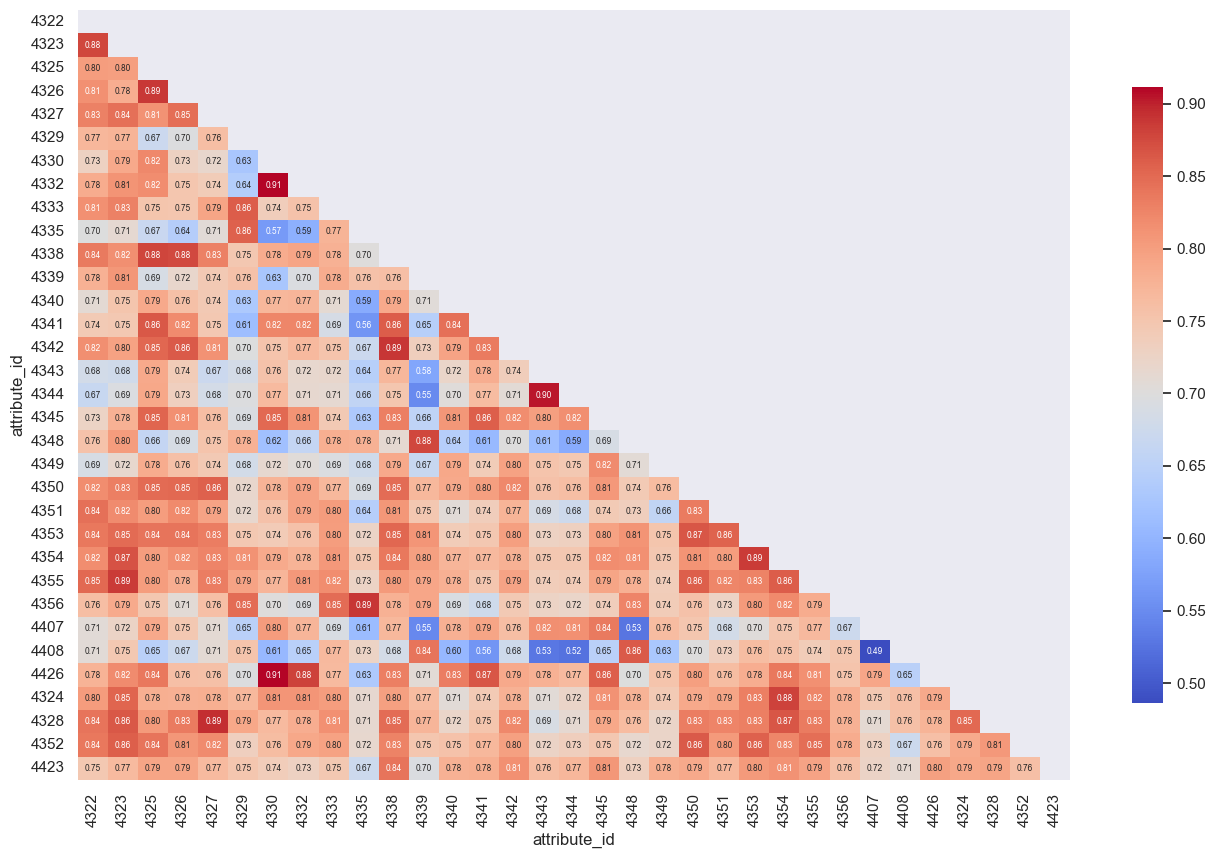

In [34]:
corr = pivot_df[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype = bool)) # Korelasyon matrisinin sadece alt üçgen kısmı görselleştirilir.
sns.set(rc = {'figure.figsize': (16,10)}, style='dark')
sns.heatmap(corr, mask = mask, cmap='coolwarm', annot = True, fmt = '.2f', annot_kws= {'size': 6}, cbar_kws={'shrink': 0.8})
plt.show()

#### 2.4 Standardizasyon İşlemi (StandardScaler)

In [35]:
# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data in num_cols
scaler.fit(pivot_df[num_cols])

# Transform the data in num_cols
pivot_df[num_cols] = scaler.transform(pivot_df[num_cols])

pivot_df[num_cols].head()

attribute_id   4322   4323   4325   4326   4327   4329   4330   4332   4333  \
0            -0.543 -0.559 -0.438 -0.767 -0.795 -0.792 -0.446 -0.123 -1.224   
1             0.595  0.561  0.683  0.723  0.723  0.404  0.728  0.691  0.459   
2             0.595  0.561  0.683  0.723  0.723  1.002  0.728  0.691  1.132   
3             0.595  1.308  0.683  0.723  1.482  1.002 -0.055  0.691  0.459   
4             0.595  0.561  1.430  0.723  0.723  0.404  2.294  1.505  0.459   

attribute_id   4335   4338   4339   4340   4341   4342   4343   4344   4345  \
0            -1.036 -1.126 -1.009 -0.542 -0.690 -0.535 -1.067 -1.206 -1.005   
1             0.996  0.632  0.840  0.912  0.799  0.588  1.230  0.750  0.742   
2             0.319  0.632  0.840  0.912  0.799  0.588  0.574  0.750  0.742   
3             0.996  1.335  1.580  0.185  0.799  0.588 -0.083  0.098  0.043   
4             0.996  0.632  0.101  0.185  0.799  1.337  0.574  0.750  0.742   

attribute_id   4348   4349   4350   4351   4353   4354   4355   4356   4407  \
0            -1.314 -1.042 -0.693 -0.436 -1.282 -1.132 -0.495 -1.235 -0.143   
1             0.879  0.670  0.848  0.717  0.814  1.053  0.632  0.915  0.530   
2             0.879  0.670  0.077  0.717  0.814  1.053  0.632  0.915  0.530   
3             0.879  1.355  0.848  0.717  0.814  0.428  0.632  0.198 -0.143   
4             0.252  1.355  0.077  0.717  0.115  0.428  0.632  0.198  1.874   

attribute_id   4408   4426   4324   4328  4352   4423  
0            -1.487 -0.253 -1.405 -0.907 0.013 -0.955  
1             0.669  1.042  0.679  0.601 0.787  0.404  
2             0.669  1.042  0.679  0.601 0.787  0.404  
3             0.669 -0.253  0.679  1.355 1.560 -0.276  
4            -0.050  1.042  1.373  0.601 0.787  1.083

### 3. ML modelin kurulması

In [36]:
# Veri setinin bağımlı ve bağımsız değişkenler olarak ayrılması
X = pivot_df.drop(['potential_label', 'player_id'], axis = 1)
y = pivot_df['potential_label']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=17) # Veri setinin train ve test olarak ayrılması

#### 2.1 En Optimum Model Bulunması (Lazy Predict Kütüphanesi)

In [44]:
clf = LazyClassifier(verbose = -1, ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test) # LazyClassifier nesnesinin fit edilmesi

100%|██████████| 29/29 [00:01<00:00, 27.25it/s]

[LightGBM] [Info] Number of positive: 42, number of negative: 174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194444 -> initscore=-1.421386
[LightGBM] [Info] Start training from score -1.421386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [46]:
models

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                     0.855              0.738    0.738     0.840   
PassiveAggressiveClassifier       0.818              0.737    0.737     0.813   
ExtraTreeClassifier               0.764              0.724    0.724     0.771   
LabelPropagation                  0.818              0.713    0.713     0.807   
DecisionTreeClassifier            0.818              0.713    0.713     0.807   
LabelSpreading                    0.818              0.713    0.713     0.807   
LGBMClassifier                    0.836              0.702    0.702     0.816   
LinearSVC                         0.800              0.678    0.678     0.784   
LogisticRegression                0.818              0.666    0.666     0.790   
RandomForestClassifier            0.818              0.666    0.666     0.790   
AdaBoostClassifier                0.782              0.666    0.666     0.769   
BaggingClassifier                 0.818              0.643    0.643     0.778   
LinearDiscriminantAnalysis        0.782              0.642    0.642     0.760   
ExtraTreesClassifier              0.800              0.631    0.631     0.763   
SGDClassifier                     0.691              0.628    0.628     0.700   
RidgeClassifier                   0.782              0.618    0.618     0.748   
SVC                               0.800              0.607    0.607     0.747   
KNeighborsClassifier              0.800              0.607    0.607     0.747   
RidgeClassifierCV                 0.782              0.595    0.595     0.733   
CalibratedClassifierCV            0.782              0.571    0.571     0.714   
Perceptron                        0.709              0.570    0.570     0.692   
QuadraticDiscriminantAnalysis     0.764              0.536    0.536     0.677   
DummyClassifier                   0.745              0.500    0.500     0.637   
BernoulliNB                       0.509              0.483    0.483     0.540   
NearestCentroid                   0.473              0.458    0.458     0.507   
GaussianNB                        0.473              0.458    0.458     0.507   

                               Time Taken  
Model                                      
XGBClassifier                       0.086  
PassiveAggressiveClassifier         0.020  
ExtraTreeClassifier                 0.015  
LabelPropagation                    0.014  
DecisionTreeClassifier              0.016  
LabelSpreading                      0.016  
LGBMClassifier                      0.071  
LinearSVC                           0.036  
LogisticRegression                  0.019  
RandomForestClassifier              0.169  
AdaBoostClassifier                  0.101  
BaggingClassifier                   0.045  
LinearDiscriminantAnalysis          0.010  
ExtraTreesClassifier                0.104  
SGDClassifier                       0.028  
RidgeClassifier                     0.022  
SVC                                 0.018  
KNeighborsClassifier                0.134  
RidgeClassifierCV                   0.010  
CalibratedClassifierCV              0.035  
Perceptron                          0.018  
QuadraticDiscriminantAnalysis       0.011  
DummyClassifier                     0.024  
BernoulliNB                         0.016  
NearestCentroid                     0.016  
GaussianNB                          0.013

#### 2.2 En Uygun Modele Hyperparameter Optimizasyonu Yapılması

In [41]:
xgboost_model = XGBClassifier(random_state = 17)

In [42]:
xgboost_params = {'learning_rate': [0.01, 0.1],
                  'max_depth': [5, 8, None],
                  'n_estimators': [100, 500, 1000],
                  'colsample_bytree': [None, 0.7, 1]}

In [43]:
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv = 5, n_jobs = -1, verbose = True).fit(X,y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [44]:
xgboost_best_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': None,
 'n_estimators': 500}

In [45]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state = 17).fit(X,y)

In [46]:
cv_results = cross_validate(xgboost_final, X,y, cv =5, scoring=['accuracy', 'f1', 'roc_auc'])

In [47]:
cv_results['test_accuracy'].mean()

0.8820202020202019

In [48]:
cv_results['test_f1'].mean()

0.6513201555926014

In [49]:
cv_results['test_roc_auc'].mean()

0.8740662438336857

#### 2.3 En önemli değişkenler (Feature Importance)

In [50]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})

    # Yeni renk paleti
    colors = sns.color_palette('viridis', len(feature_imp))

    plt.figure(figsize=(8, 5))
    sns.set(font_scale=1)

    # Özellikleri sıralıyoruz ve renk paletini bağlıyoruz
    sorted_features = feature_imp.sort_values(by='Value', ascending=False)[0:num]
    sns.barplot(
        x='Value',
        y='Feature',
        data=sorted_features,
        palette=colors[:num]
    )

    plt.title('Feature')
    plt.tight_layout()
    plt.show()

    if save:
        plt.savefig('importances.png')

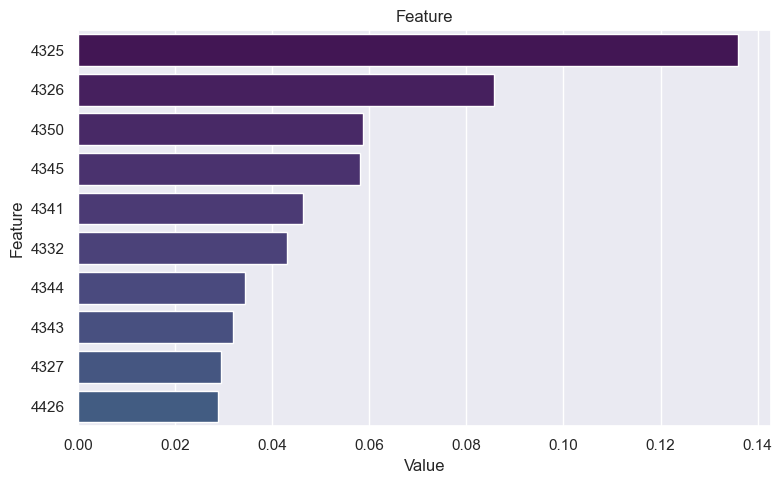

In [51]:
plot_importance(xgboost_final, X, num = 10)

In [64]:
random = X.sample(3, random_state = 17)
random

attribute_id  position_id   4322   4323   4324   4325   4326   4327   4328  \
218                     2 -0.922 -0.186 -1.405 -1.559 -1.511 -0.036 -0.153   
164                     7  1.354 -0.186  0.679  2.177  1.467  0.723  0.601   
233                     3  1.354  1.308  0.679  0.683  0.723  1.482  1.355   

attribute_id   4329   4330   4332   4333  4335   4338  4339   4340   4341  \
218          -0.194 -1.621 -1.750 -0.214 0.319 -0.775 0.101 -1.996 -2.180   
164           0.404  0.728  2.319  0.459 0.319  1.335 0.101  0.185  2.289   
233           1.002  0.728  0.691  0.459 0.996  1.335 0.840  0.912  0.799   

attribute_id   4342   4343   4344   4345  4348   4349   4350   4351   4352  \
218          -1.658 -1.395 -1.206 -1.354 0.252 -0.699 -1.464 -0.820 -1.535   
164           1.337  0.574  0.750  1.441 0.252  1.355  0.848  0.717  0.787   
233           1.337  0.574  0.750  0.742 0.879  1.355  0.848  0.717  0.787   

attribute_id   4353   4354   4355  4356   4357   4407   4408   4423   4426  
218          -0.583 -0.196 -0.870 0.198 56.000 -2.160 -0.769 -1.635 -1.547  
164           0.814 -0.196  0.632 0.198 56.000  0.530 -0.050  1.083  1.042  
233           0.814  1.053  0.632 0.915 67.000  0.530  0.669  1.083  1.042

In [65]:
prediction = xgboost_final.predict(random)
prediction

array([0, 1, 0])